In [118]:
# Fundamentos de Ciência de Dados
## PPGI/UFRJ 2024.2
### Profs Sergio Serra e Jorge Zavaleta
### Aluno Ubirajara S. Santos

In [119]:
import prov
import os
import sys
import datetime
import plotly
import graphviz
import unicodedata
import platform
import importlib.metadata
import pandas as pd
import numpy as np
import matplotlib
import openpyxl
import requests
import zipfile
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import folium
import json
import logging
import re
#import difflib
from prov.model import ProvDocument, Namespace
from prov.dot import prov_to_dot
from IPython.display import Image
from pathlib import Path
from io import BytesIO
from difflib import get_close_matches
from folium import GeoJson
from shapely.geometry import mapping
from shapely.geometry import Point
from datetime import datetime
from pyproj import CRS
from matplotlib.patches import Patch

In [120]:
OUTPUT_DIR = './dados/saidas'
os.makedirs(OUTPUT_DIR, exist_ok=True) 

In [121]:
# Fontes de Dados
data_sources = {
     "amostras_rochas_fluidos": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-amostras-de-rochas-e-fluidos/acervo-de-amostras/consolidacao-2023.zip",
        "type": "zip"},
     "setores_sirgas": {
        "url": "https://www.gov.br/anp/pt-br/assuntos/exploracao-e-producao-de-oleo-e-gas/estudos-geologicos-e-geofisicos/arquivos-classificacao-de-modelos-exploratorios/setores-sirgas.zip",
        "type": "zip"},
     "bacias":{
        "url":"https://geomaps.anp.gov.br/geoserver/wfs?service=wfs&version=1.0.0&request=GetFeature&typeName=sisroc:bacias_gishub_db&outputFormat=SHAPE-ZIP&format_options=filename:Bacias-zip",
        "type": "zip"},
     "blocos_exploratorios": {
        "url": "https://gishub.anp.gov.br/geoserver/BD_ANP/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=BD_ANP%3ABLOCOS_EXPLORATORIOS_SIRGAS&maxFeatures=40000&outputFormat=SHAPE-ZIP",
        "type": "zip"},
     "campos_producao": {
        "url": "https://gishub.anp.gov.br/geoserver/BD_ANP/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=BD_ANP%3ACAMPOS_PRODUCAO_SIRGAS&maxFeatures=40000&outputFormat=SHAPE-ZIP",
        "type": "zip"},
     "reservas_nacionais_hc": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-estatisticos/arquivos-reservas-nacionais-de-petroleo-e-gas-natural/tabela-dados-bar-2023.xlsx",
        "type": "xlsx"},
     "pocos_perfurados_2023": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-acervo-de-dados-tecnicos/pocos-publicos-2023.csv",
        "type": "csv"},
     "tabela_levantamentos_geoquimica": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-acervo-de-dados-tecnicos/tabela-levantamentos-geoquimicos.csv",
        "type": "csv"},
     "levantamento_sismico_2023": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-acervo-de-dados-tecnicos/sismicos-publicos-2023.csv",
        "type": "csv"},
     "tabela_pocos_2024": {
        "url": "./dados/raw/Tabela_pocos_2024_Novembro_24.csv",
        "type": "csv", "sep": ";" ,"encoding": "ANSI"},
     "tabela_dados_geoquimica": {
        "url": "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos-acervo-de-dados-tecnicos/tabela-dados-geoquimicos.csv",
        "type": "csv",
        "header": 1}
}

In [122]:
#FUNÇÂO EM USO

def gerar_prov_outputs(doc_prov):
    entity = "EDA-PROV"
    output_file = f"{entity}.png"
    try:
        dot = prov_to_dot(doc_prov)
        # Write to PNG
        dot.write_png(output_file)
        print(f"Provenance graph generated successfully: {output_file}")

    except Exception as e:
        print(f"Error generating provenance graph: {e}")
        # Save the DOT file for debugging
        with open("debug.dot", "w") as f:
            f.write(dot.to_string())
        print("Saved DOT file for debugging as 'debug.dot'.")

    # Serialização do documento
    doc_prov.serialize(entity + ".xml", format='xml') 
    doc_prov.serialize(entity + ".ttl", format='rdf', rdf_format='ttl',encoding="utf-8")
    print("Provenance serialized as XML and TTL.")


def adding_namespaces(document_prov):
    # Adiciona namespaces ao documento de proveniência.
    document_prov.add_namespace('void', 'http://vocab.deri.ie/void#')
    document_prov.add_namespace('ufrj', 'https://www.ufrj.br')
    document_prov.add_namespace('schema', 'http://schema.org/')    # Dados estruturados Schema.org
    document_prov.add_namespace('prov', 'http://www.w3.org/ns/prov#')     # Padrões PROV
    document_prov.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')     # Agentes FOAF
    document_prov.add_namespace('ufrj-ppgi', 'http://www.ufrj.br/ppgi/')  # UFRJ PPGI
    document_prov.add_namespace('anp', 'https://www.gov.br/anp/pt-br')    # ANP - Agência Nacional do Petróleo, Gás Natural e Biocombustíveis
    document_prov.add_namespace('anp-dados_tec','https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/acervo-de-dados-tecnicos') # ANP - Acervo de Dados Técnicos 
    document_prov.add_namespace('petrobras','https://petrobras.com.br/')  # PETROBRAS
    document_prov.add_namespace('br','http://br.org/ns/')    # Organizações Brasileiras
    document_prov.add_namespace('git','https://github.com/ubirajara-s/eda') # Githut do repositório projeto EDA
    return document_prov


def escape_label(text):
    """
    Escapes special characters for Graphviz.
    Encodes text to ASCII with XML character references.
    """
    return text.encode("ascii", "xmlcharrefreplace").decode()

def get_installed_packages():
    #Retorna os pacotes instalados no ambiente com suas versões.
    try:
        return {pkg.metadata['Name']: pkg.version for pkg in importlib.metadata.distributions()}
    except ImportError:
        import pkg_resources
        return {dist.project_name: dist.version for dist in pkg_resources.working_set}

def get_system_info():
    #Retorna informações do sistema.
    return {
        "OS": platform.system(),
        "OS Version": platform.version(),
        "OS Release": platform.release(),
        "Python Version": sys.version,
        "Python Executable": sys.executable,
        "Current Working Directory": str(Path.cwd()),}

def get_used_packages():

    #Retorna um dicionário dos pacotes usados explicitamente no projeto e suas versões.

    packages = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'rdflib', 'prov', 'graphviz', 
                'openpyxl', 'folium', 'pydot', 'requests', 'geopandas', 'plotly','ipython', 'contextily', 'difflib']  # Adicione ou remova pacotes usados
    package_versions = {}
    for package in packages:
        try:
            import importlib.metadata
            version = importlib.metadata.version(package)
            package_versions[package] = version
        except ImportError:
            print(f"Pacote {package} não encontrado.")
    return package_versions

def add_system_and_package_provenance(doc_prov):
    #Adiciona informações do sistema e pacotes ao documento de proveniência

    # Criar atividade para rastrear informações de sistema e pacotes
    activity_id = "ufrj:track_system_and_packages"
    tracking_activity = doc_prov.activity(activity_id, datetime.now(), None, {"prov:label": escape_label("Track system and package provenance")})

    # Associar a atividade ao agente do notebook
    if "ag-eda-ipynb" in dict_agents:
        doc_prov.wasAssociatedWith(tracking_activity, dict_agents["ag-eda-ipynb"])

    # Adicionar informações do sistema como entidades
    system_info = get_system_info()
    for key, value in system_info.items():
        sanitized_key = key.replace(" ", "_")  # Substituir espaços por _
        sys_entity = doc_prov.entity(f"schema:{sanitized_key}", {"prov:value": value})
        doc_prov.wasGeneratedBy(sys_entity, tracking_activity)

    # Adicionar pacotes usados como entidades
    used_packages = get_used_packages()
    for pkg, version in used_packages.items():
        pkg_entity = doc_prov.entity(f"schema:{pkg}", {"prov:value": version})
        doc_prov.wasGeneratedBy(pkg_entity, tracking_activity)

    return doc_prov

def create_agents(document_prov):

    #creating agents
    dagnts={} #cria dic
    dagnts["ag-orgbr"] = document_prov.agent("br:orgBr", {"prov:type":"prov:Organization", "foaf:name":escape_label("Oraganizações Brasileiras")})
    dagnts["ag-anp"] = document_prov.agent("anp:ANP", {"prov:type":"prov:Organization", "foaf:name":escape_label("Agência Nacional do Petróleo, Gás Natural e Biocombustíveis")})
    dagnts["ag-ufrj"] = document_prov.agent("ufrj:UFRJ", {"prov:type":"prov:Organization", "foaf:name":escape_label("Universidade Federal do Rio de Janeiro")})
    dagnts["ag-ppgi"] = document_prov.agent("ufrj:PPGI", {"prov:type":"prov:Organization", "foaf:name":escape_label("Programa de Pós Graduação em Informática")})
    dagnts["ag-greco"] = document_prov.agent("ufrj:GRECO", {"prov:type":"prov:Organization", "foaf:name":escape_label("Grupo de Engenharia do Conhecimento")})
    dagnts["ag-author-ubirajara"] = document_prov.agent("ufrj:Ubirajara", {"prov:type":"prov:Person", "foaf:name":escape_label("Ubirajara Simões Santos"), "foaf:mbox":"ubirajas@hotmail.com"})
    dagnts["ag-author-sergio"] = document_prov.agent("ufrj:Sergio", {"prov:type":"prov:Person", "foaf:name":escape_label("Sergio Serra"), "foaf:mbox":"serra@ppgi.ufrj.br"})
    dagnts["ag-author-jorge"] = document_prov.agent("ufrj:Jorge", {"prov:type":"prov:Person", "foaf:name":escape_label("Jorge Zavaleta"), "foaf:mbox":"zavaleta@pet-si.ufrrj.br"})
    dagnts["ag-petrobras"] = document_prov.agent("petrobras:Petrobras", {"prov:type":"prov:Organization", "foaf:name":escape_label("Petróleo Brasiliero S.A")})
    dagnts["ag-eda-ipynb"] = document_prov.agent("ufrj:eda.ipynb", {"prov:type":"prov:SoftwareAgent", "foaf:name":escape_label("eda.ipynb"), "prov:label":escape_label("Notebook Python utilizado no trabalho")})
    return dagnts

def associate_ufrj_agents(agents_dictionary):
    agents_dictionary["ag-anp"].actedOnBehalfOf(agents_dictionary["ag-orgbr"])
    agents_dictionary["ag-petrobras"].actedOnBehalfOf(agents_dictionary["ag-orgbr"])
    agents_dictionary["ag-ufrj"].actedOnBehalfOf(agents_dictionary["ag-orgbr"])
    agents_dictionary["ag-ppgi"].actedOnBehalfOf(agents_dictionary["ag-ufrj"])
    agents_dictionary["ag-greco"].actedOnBehalfOf(agents_dictionary["ag-ppgi"])
    agents_dictionary["ag-author-ubirajara"].actedOnBehalfOf(agents_dictionary["ag-greco"])
    agents_dictionary["ag-author-ubirajara"].actedOnBehalfOf(agents_dictionary["ag-petrobras"])
    agents_dictionary["ag-author-sergio"].actedOnBehalfOf(agents_dictionary["ag-ppgi"])
    agents_dictionary["ag-author-jorge"].actedOnBehalfOf(agents_dictionary["ag-ppgi"])
    agents_dictionary["ag-eda-ipynb"].actedOnBehalfOf(agents_dictionary["ag-ppgi"])
    return agents_dictionary


def create_initial_activities(document_prov):
    #creating activities
    #dataDownloadDatasets = datetime.datetime.strptime('29/11/24', '%d/%m/%y')

    dativs={}
    dativs["act-create-ds"] = document_prov.activity("anp:create-dataset", None, None, {"prov:label":escape_label( "Criação de datasets pela ANP")})
    #dativs["act-extract-ds"] = document_prov.activity("ufrj:extract-dataset")
    dativs["act-create-ds-eda"] = document_prov.activity("ufrj:create-ds-eda", None, None, {"prov:label":escape_label( "Criação de datasets para EDA")})
    #dativs["act-load-ds-eda"] = document_prov.activity("ufrj:load-ds-eda")
    dativs["act-save-ipynb"] = document_prov.activity("ufrj:save-ipynb", None, None, {"prov:label":escape_label("Salvar notebook EDA")})
    return dativs

def cria_entidades_iniciais(document_prov):
    global dict_entities  # Adicionar entidades ao dicionário global
    #creating entidades
    dents={}

    # Entidade para amostras de rochas e fluidos
    dents["ent-amostras-rochas-fluidos"] = document_prov.entity('anp:amostras_rochas_fluidos', {'prov:label':escape_label('Dataset com amostras de rochas e fluidos'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Consolidado 2023 de amostras disponíveis.'), 'prov:format': 'zip' })
    # Entidade para setores SIRGAS
    dents["ent-setores-sirgas"] = document_prov.entity('anp:setores_sirgas', {'prov:label':escape_label('Setores SIRGAS'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Modelos exploratórios em formato SIRGAS.'), 'prov:format': 'zip'})
    # Entidade para Bacias
    dents["ent-bacias"] = document_prov.entity('anp:bacias', {'prov:label':escape_label('Bacias Sedimentares'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Mapas Bacias Sedimentares.'), 'prov:format': 'zip'})
    # Entidade para blocos exploratórios
    dents["ent-blocos-exploratorios"] = document_prov.entity('anp:blocos_exploratorios', {'prov:label':escape_label( 'Blocos exploratórios'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Blocos exploratórios com dados geoespaciais.'), 'prov:format': 'zip'})
    # Entidade para campos de produção
    dents["ent-campos-producao"] = document_prov.entity('anp:campos_producao', {'prov:label':escape_label( 'Campos de Produção'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Dados dos campos de produção em formato SIRGAS.'), 'prov:format': 'zip'})
    # Entidade para reservas nacionais de hidrocarbonetos
    dents["ent-reservas-nacionais-hc"] = document_prov.entity('anp:reservas_nacionais_hc',{'prov:label':escape_label( 'Reservas Nacionais de Hidrocarbonetos'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Tabela com dados sobre reservas nacionais.'), 'prov:format': 'xlsx'})
    # Entidade para poços perfurados (2023)
    dents["ent-pocos-perfurados-2023"] = document_prov.entity('anp:pocos_perfurados_2023',{'prov:label':escape_label( 'Poços perfurados - 2023'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('CSV com os poços perfurados no ano de 2023.'), 'prov:format': 'csv'})
    # Entidade para tabela de levantamentos geoquímicos
    dents["ent-tabela-levantamentos-geoquimica"] = document_prov.entity('anp:tabela_levantamentos_geoquimica',{'prov:label':escape_label( 'Tabela de levantamentos geoquímicos 20/04/2022'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Dados sobre levantamentos geoquímicos.'), 'prov:format': 'csv'})
     # Entidade para tabela de dados geoquímicos
    dents["ent-tabela-dados-geoquimica"] = document_prov.entity('anp:tabela_dados_geoquimica',{'prov:label':escape_label( 'Tabela_dados_geoquimica 06/08/2021'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Dados geoquímicos.'), 'prov:format': 'csv'})
     # Entidade para levantamento sísmico (2023)
    dents["ent-levantamento-sismico-2023"] = document_prov.entity('anp:levantamento_sismico_2023', {'prov:label':escape_label( 'Levantamento Sísmico - 2023'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('CSV com dados de levantamentos sísmicos públicos.'), 'prov:format': 'csv'})
    # Entidade para tabela de poços (2024)
    dents["ent-tabela-pocos-2024"] = document_prov.entity('anp:tabela_pocos_2024', {'prov:label':escape_label( 'Tabela de Poços - 2024'.encode("ascii", "xmlcharrefreplace").decode()), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Tabela CSV com dados atualizados de poços para 2024.'), 'prov:format': 'csv'})
     # Entidade para ANP dados técnicos
    dents["ent-anp-dados_tec-ds"] = document_prov.entity('anp-dados_tec:dataset', {'prov:label':escape_label( 'ANP Dataset de Dados Técnicos'.encode("ascii", "xmlcharrefreplace").decode()),'prov:type': 'void:Dataset','prov:description':escape_label('Dataset com dados técnicos disponíveis publicamente.'),'prov:format': 'csv'})
    # Entidade script python
    dents["ent-eda-ipynb"] = document_prov.entity('ufrj:eda-ipyn', {'prov:label':escape_label( "Notebook Python utilizado no trabalho".encode("ascii", "xmlcharrefreplace").decode()), 'prov:type': 'foaf:Document'})
    # Entidade Git
    dents["ent-git-eda"] = document_prov.entity('git:github-eda', {'prov:label':escape_label( 'Repositorio GIT projeto EDA '.encode("ascii", "xmlcharrefreplace").decode()), 'prov:type': 'prov:Collection'})
    return dents


    dict_entities.update({
        "ent-setores-sirgas": document_prov.entity(
            'anp:setores_sirgas',{'prov:label': escape_label('Setores SIRGAS'),'prov:type': 'void:Dataset','prov:description': escape_label('Modelos exploratórios em formato SIRGAS.'),
                'prov:format': 'zip'}),
        "ent-blocos-exploratorios": document_prov.entity(
            'anp:blocos_exploratorios',{'prov:label': escape_label('Blocos exploratórios'),'prov:type': 'void:Dataset','prov:description': escape_label('Blocos exploratórios com dados geoespaciais.'),
                'prov:format': 'zip'}),
        "ent-campos-producao": document_prov.entity(
            'anp:campos_producao',{'prov:label': escape_label('Campos de Produção'),'prov:type': 'void:Dataset','prov:description': escape_label('Dados dos campos de produção em formato SIRGAS.'),
                'prov:format': 'zip'}),
        "ent-bacias": document_prov.entity(
            'anp:bacias', {'prov:label':escape_label('Bacias Sedimentares'), 'prov:type': 'void:Dataset', 'prov:description':escape_label('Mapas Bacias Sedimentares.'),
                'prov:format': 'zip'}),
    })

def initial_association_agents_activities_entities(document_prov, dictionary_agents, dictionary_activities, dictionary_entities):

    #Associate activity of generate dataset with ANP agent
    document_prov.wasAssociatedWith(dictionary_activities["act-create-ds"], dictionary_agents["ag-anp"])

    #Associating datasets with activities of generate eba datasets
    document_prov.wasGeneratedBy(dictionary_entities["ent-amostras-rochas-fluidos"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-setores-sirgas"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-bacias"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-blocos-exploratorios"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-campos-producao"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-reservas-nacionais-hc"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-pocos-perfurados-2023"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-tabela-levantamentos-geoquimica"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-tabela-dados-geoquimica"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-levantamento-sismico-2023"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-tabela-pocos-2024"], dictionary_activities["act-create-ds"])
    document_prov.wasGeneratedBy(dictionary_entities["ent-anp-dados_tec-ds"], dictionary_activities["act-create-ds"])

    #associate activity of eda, com autor
    document_prov.wasAssociatedWith(dictionary_activities["act-create-ds-eda"], dictionary_agents["ag-author-ubirajara"])   

    #associate notebook agent with eba dataset
    document_prov.wasAssociatedWith(dictionary_activities["act-create-ds-eda"], dictionary_agents["ag-eda-ipynb"])    

    #associate eda github repository with store datasets activity
    document_prov.wasGeneratedBy(dictionary_entities["ent-git-eda"], dictionary_activities["act-save-ipynb"])

def associate_save_activity(doc_prov, dict_agents, dict_entities):

    #Associa a atividade de salvar notebook ao agente e à entidade relevante.

    activity_id = "ufrj:save-ipynb"
    save_activity = doc_prov.activity(activity_id, datetime.now(), None, {"prov:label": escape_label("Salvar notebook EDA")})
    # Associar ao agente eda.ipynb
    if "ag-eda-ipynb" in dict_agents:
        doc_prov.wasAssociatedWith(save_activity, dict_agents["ag-eda-ipynb"])

    # Associar à entidade eda-ipynb
    if "ent-eda-ipynb" in dict_entities:
        doc_prov.wasGeneratedBy(dict_entities["ent-eda-ipynb"], save_activity)

    return doc_prov


def initProvenance(existing_prov_file=None, full_initialization=False):
    #Inicializa o documento de proveniência com namespaces, agentes, atividades e entidades.

    global dict_agents, dict_activities, dict_entities

    # Criando um documento vazio de proveniência
    doc_prov = ProvDocument()

    # Try to load existing provenance file
    # Attempt to load an existing provenance file
    if existing_prov_file and os.path.exists(existing_prov_file):
        try:
            with open(existing_prov_file, "r", encoding="utf-8") as file:
                content = file.read().strip()
                if content:
                    doc_prov = ProvDocument.deserialize(existing_prov_file)
                    logging.info(f"Provenance loaded from {existing_prov_file}")
                else:
                    logging.warning(f"Provenance file '{existing_prov_file}' is empty. Creating a new document.")
        except Exception as e:
            logging.error(f"Error loading existing provenance: {e}. Creating a new document.")

    dict_agents = {}
    dict_activities = {}
    dict_entities = {}

    # Criar namespaces no documento de proveniência
    doc_prov = adding_namespaces(doc_prov)

    # GArantir`ag-eda-ipynb` está sempre adicionadp
    dict_agents["ag-eda-ipynb"] = doc_prov.agent("ufrj:eda.ipynb", {"prov:type": "prov:SoftwareAgent"})

    
    # Perform full initialization if requested
    if full_initialization:
        # Criar agentes
        dict_agents = create_agents(doc_prov)
        # Criar atividades iniciais
        dict_activities = create_initial_activities(doc_prov)
        # Criar entidades iniciais e atualizar o dicionário global
        cria_entidades_iniciais(doc_prov)
        # Criar entidades iniciais
        dict_entities = cria_entidades_iniciais(doc_prov)
        # Criar hierarquia de agentes
        dict_agents = associate_ufrj_agents(dict_agents)
        # Associar agentes, atividades e entidades
        initial_association_agents_activities_entities(doc_prov, dict_agents, dict_activities, dict_entities)
        # Adicionar proveniência do sistema e pacotes
        doc_prov = add_system_and_package_provenance(doc_prov)
        # Associar atividade ufrj:save-ipynb
        doc_prov = associate_save_activity(doc_prov, dict_agents, dict_entities)

    return doc_prov, dict_agents, dict_activities, dict_entities


In [123]:
#FUNÇÂO EM USO
def analyze_zip_content(url, temp_dir="./dados/temp"):
    """
    Analisa o conteúdo de um arquivo ZIP e categoriza os tipos de arquivos encontrados.
    Args:
        url (str): URL para o arquivo ZIP.
        temp_dir (str): Diretório temporário para extração dos arquivos.
    Returns:
        dict: Dicionário com categorias de arquivos (csv, xlsx, shp, others).
    """
    os.makedirs(temp_dir, exist_ok=True)
    file_types = {"csv": [], "xlsx": [], "xls": [], "shp": [], "others": []}

    try:
        # Baixar o arquivo ZIP
        response = requests.get(url)
        if response.status_code != 200:
            raise ValueError(f"Erro ao baixar o arquivo: {response.status_code}")

        # Abrir o ZIP em memória e extrair
        with zipfile.ZipFile(BytesIO(response.content)) as zf:
            zf.extractall(temp_dir)
            extracted_files = zf.namelist()

        # Categorizar os arquivos extraídos
        for file in extracted_files:
            file_path = os.path.join(temp_dir, file)
            if file.endswith(".csv"):
                file_types["csv"].append({"name": os.path.basename(file), "path": file_path})
            elif file.endswith(".xlsx"):
                file_types["xlsx"].append({"name": os.path.basename(file), "path": file_path})
            elif file.endswith(".xls"):
                file_types["xls"].append({"name": os.path.basename(file), "path": file_path})
            elif file.endswith(".shp"):
                file_types["shp"].append({"name": os.path.basename(file), "path": file_path})
            else:
                file_types["others"].append({"name": os.path.basename(file), "path": file_path})

        print(f"Conteúdo do ZIP analisado: {file_types}")
        return file_types

    except zipfile.BadZipFile:
        print(f"O arquivo fornecido não é um ZIP válido: {url}")
        return None
    except Exception as e:
        print(f"Erro ao processar ZIP: {e}")
        return None

In [124]:
"""def diagnose_csv(file_path, encodings=["utf-8", "ISO-8859-1", "utf-8-sig"]):

    #Diagnostica problemas em arquivos CSV: delimitador e encoding.

    print(f"Diagnóstico do arquivo: {file_path}")
    for encoding in encodings:
        try:
            print(f"Tentando com encoding: {encoding}")
            with open(file_path, "r", encoding=encoding) as f:
                sample = f.read(2048)  # Lê os primeiros 2048 caracteres
            print(f"Primeiros caracteres ({encoding}):")
            print(sample[:500])  # Mostra apenas os primeiros 500 caracteres
            print("\n--- Fim da Amostra ---\n")
        except Exception as e:
            print(f"Erro ao ler o arquivo com encoding {encoding}: {e}")"""

'def diagnose_csv(file_path, encodings=["utf-8", "ISO-8859-1", "utf-8-sig"]):\n\n    #Diagnostica problemas em arquivos CSV: delimitador e encoding.\n\n    print(f"Diagnóstico do arquivo: {file_path}")\n    for encoding in encodings:\n        try:\n            print(f"Tentando com encoding: {encoding}")\n            with open(file_path, "r", encoding=encoding) as f:\n                sample = f.read(2048)  # Lê os primeiros 2048 caracteres\n            print(f"Primeiros caracteres ({encoding}):")\n            print(sample[:500])  # Mostra apenas os primeiros 500 caracteres\n            print("\n--- Fim da Amostra ---\n")\n        except Exception as e:\n            print(f"Erro ao ler o arquivo com encoding {encoding}: {e}")'

In [125]:
"""def report_unknown_files(unknown_files):

    #Exibe uma mensagem com arquivos de formatos não reconhecidos e registra a proveniência.
    #Args:
    #    unknown_files (list): Lista de dicionários com informações sobre arquivos não reconhecidos.
    #        Cada dicionário contém:
    #            - 'name': Nome do arquivo.
    #            - 'path': Caminho completo para o arquivo.

    global doc_prov, dict_agents, dict_activities, dict_entities  # Proveniência

    if unknown_files:
        print(f"Arquivos não reconhecidos encontrados: {[file['name'] for file in unknown_files]}")

        # Registrar proveniência da análise
        exec_start = datetime.now()
        activity_key = "act-analyze-unknown-files"
        dict_activities[activity_key] = doc_prov.activity(
            "ufrj:analyze_unknown_files",
            exec_start,
            None,
            {"prov:label": escape_label("Análise de arquivos desconhecidos")}
        )
        doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

        # Criar entidades para cada arquivo desconhecido
        for file_info in unknown_files:
            entity_key = f"ent-unknown-{file_info['name']}"
            dict_entities[entity_key] = doc_prov.entity(
                f"ufrj:unknown_{file_info['name']}",
                {"prov:label": escape_label(f"Arquivo desconhecido: {file_info['name']}"),
                 "prov:type": "void:Dataset",
                 "prov:location": file_info["path"]}
            )
            doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

    else:
        print("Nenhum arquivo não reconhecido foi encontrado.")    """

'def report_unknown_files(unknown_files):\n\n    #Exibe uma mensagem com arquivos de formatos não reconhecidos e registra a proveniência.\n    #Args:\n    #    unknown_files (list): Lista de dicionários com informações sobre arquivos não reconhecidos.\n    #        Cada dicionário contém:\n    #            - \'name\': Nome do arquivo.\n    #            - \'path\': Caminho completo para o arquivo.\n\n    global doc_prov, dict_agents, dict_activities, dict_entities  # Proveniência\n\n    if unknown_files:\n        print(f"Arquivos não reconhecidos encontrados: {[file[\'name\'] for file in unknown_files]}")\n\n        # Registrar proveniência da análise\n        exec_start = datetime.now()\n        activity_key = "act-analyze-unknown-files"\n        dict_activities[activity_key] = doc_prov.activity(\n            "ufrj:analyze_unknown_files",\n            exec_start,\n            None,\n            {"prov:label": escape_label("Análise de arquivos desconhecidos")}\n        )\n        doc_pr

In [126]:
def update_data_sources_with_zip(data_sources, source_name, temp_dir="./dados/temp"):
    """
    Atualiza `data_sources` com os arquivos extraídos de um ZIP, criando uma relação hierárquica.
    """
    # Obter fonte original
    source = data_sources.get(source_name)
    if not source or source.get("type") != "zip":
        print(f"Fonte '{source_name}' não encontrada ou não é um ZIP.")
        return data_sources

    # Analisar o conteúdo do ZIP
    file_types = analyze_zip_content(source["url"], temp_dir=temp_dir)
    if not file_types:
        print(f"Erro ao processar ZIP '{source_name}'.")
        return data_sources

    # Criar relações de proveniência
    for file_type, files in file_types.items():
        if not files:
            continue

        for i, file_info in enumerate(files):
            child_name = f"{source_name}_{file_type}_{i+1}"
            data_sources[child_name] = {
                "url": file_info["path"],  # Caminho local do arquivo extraído
                "type": file_type,        # Tipo do arquivo (csv, xlsx, shp, etc.)
                "parent": source_name,    # Referência ao ZIP pai
                "sep": source.get("sep", ";") if file_type == "csv" else None,
                "encoding": source.get("encoding", "utf-8") if file_type == "csv" else None,
                "header": source.get("header", 0) if file_type == "csv" else None,
                "date_columns": source.get("date_columns", []) if file_type == "csv" else None,
            }
            print(f"Adicionado {child_name} como filho de {source_name}.")

    print(f"Data sources atualizados com arquivos de '{source_name}'.")
    return data_sources

In [127]:
"""def register_provenance_for_zip_and_children(parent_source, children_sources, activity_prefix="process-zip"):
    
    #Registra a proveniência entre o ZIP pai e os arquivos extraídos (filhos).
    #A atividade é associada ao agente 'ag-eda-ipynb' para todos os filhos.
    
    global doc_prov, dict_agents, dict_activities, dict_entities

    # Criar atividade para o processamento do ZIP
    exec_start = datetime.now()
    activity_key = f"{activity_prefix}-{parent_source}"
    dict_activities[activity_key] = doc_prov.activity(
        f"ufrj:{activity_prefix}_{parent_source}", exec_start, None,
        {"prov:label": escape_label(f"Processamento do ZIP {parent_source}")}
    )
    doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

    # Registrar cada filho como derivado do pai
    for child_source in children_sources:
        entity_key = f"ent-{child_source}"
        dict_entities[entity_key] = doc_prov.entity(f"ufrj:{child_source}", {
            "prov:label": escape_label(f"Arquivo derivado de {parent_source}"),
            "prov:type": "void:Dataset"
        })

        # Relacionar pai e filho
        doc_prov.wasDerivedFrom(
            dict_entities[entity_key], dict_entities.get(f"ent-{parent_source}")
        )
        doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

        # Adiciona a atividade de proveniência do arquivo como "gerado por" o agente IPYNB
        doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

    print(f"Proveniência registrada para arquivos derivados de {parent_source}.")"""


'def register_provenance_for_zip_and_children(parent_source, children_sources, activity_prefix="process-zip"):\n    \n    #Registra a proveniência entre o ZIP pai e os arquivos extraídos (filhos).\n    #A atividade é associada ao agente \'ag-eda-ipynb\' para todos os filhos.\n    \n    global doc_prov, dict_agents, dict_activities, dict_entities\n\n    # Criar atividade para o processamento do ZIP\n    exec_start = datetime.now()\n    activity_key = f"{activity_prefix}-{parent_source}"\n    dict_activities[activity_key] = doc_prov.activity(\n        f"ufrj:{activity_prefix}_{parent_source}", exec_start, None,\n        {"prov:label": escape_label(f"Processamento do ZIP {parent_source}")}\n    )\n    doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])\n\n    # Registrar cada filho como derivado do pai\n    for child_source in children_sources:\n        entity_key = f"ent-{child_source}"\n        dict_entities[entity_key] = doc_prov.entity(f"ufrj:{child_

In [128]:
#FUNÇÂO EM USO
def load_data_from_source_csv(source_name, data_sources):
    """
    Carrega dados com base no nome da fonte e na configuração em data_sources.
    Returns:
        pd.DataFrame: DataFrame com os dados carregados, ou None se houver erro.
    """
    global doc_prov, dict_agents,  dict_activities, dict_entities  # Declare global variables
    #save execution start time
    execStartTime = datetime.now()

    source = data_sources.get(source_name)

    if not source: #or source.get("type") != "csv":
        print(f"Fonte '{source_name}' não encontrada ou não é do tipo CSV.")
        return None

    file_type = source.get("type")
    url = source.get("url")
    sep = source.get("sep", ";")  # Valor padrão para CSV
    encoding = source.get("encoding", "utf-8")  # Valor padrão para codificação
    date_columns = source.get("date_columns", [])  

    try:
        if file_type == "csv":
             # Caso específico para tabela_pocos_2024
            if source_name == "tabela_pocos_2024":
                df = pd.read_csv(url, encoding="latin-1", sep=sep)
            # Caso específico para tabela_dados_geoquimica
            elif source_name == "tabela_dados_geoquimica":
                df = pd.read_csv(url, sep=sep, encoding=encoding, header=1)  # Cabeçalho na segunda linha
            else:
                df = pd.read_csv(url, sep=sep, encoding=encoding, parse_dates=date_columns)
        elif file_type == "xlsx":
            df = pd.read_excel(url)
        else:
            print(f"Tipo de arquivo '{file_type}' não suportado.")
            return None
        print(f"Dados carregados com sucesso para '{source_name}'.")

        # End execution time for provenance tracking
        execEndTime = datetime.now()

        # Criar atividade com horário de término da execução
        activity_key = f"act-carga-{source_name}"
        dict_activities[activity_key] = doc_prov.activity(f"ufrj:carga_{source_name}", execStartTime, execEndTime)

        # Associar a atividade ao agente
        doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

        # Associar a atividade com os dados carregados
        entity_key = f"ent-{source_name}"
        dict_entities[entity_key] = doc_prov.entity(f"ufrj:{source_name}", {"prov:label": escape_label(f"Dataset carregado: {source_name}"),"prov:type": "void:Dataset", "prov:generatedAtTime": execEndTime.isoformat(),})
        doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

        # Associar a atividade ufrj:carga à entidade correspondente criada pela ANP
        anp_entity_key = f"ent-{source_name.replace('_', '-')}"  # Convert to ANP format (e.g., `tabela_pocos_2024` -> `ent-tabela-pocos-2024`)
        if anp_entity_key in dict_entities:
            # Establish the prov:used relationship
            doc_prov.used(dict_activities[activity_key], dict_entities[anp_entity_key])
        else:
            print(f"Warning: ANP entity '{anp_entity_key}' not found for activity '{activity_key}'.")
        return df

    except Exception as e:
        print(f"Erro ao carregar dados de '{source_name}': {e}")
        return None

In [129]:
#FUNÇÂO EM USO
def process_zip_source_shp(source_name, data_sources, temp_dir="./dados/temp", output_dir="./dados/shp_salvos"):
    """
    Processa um ZIP contendo arquivos SHP, descompacta e carrega os arquivos como GeoDataFrames.
    Também salva os arquivos SHP extraídos em um diretório de saída.
    Args:
        source_name (str): Nome da fonte de dados.
        data_sources (dict): Dicionário com informações das fontes de dados.
        temp_dir (str): Diretório temporário para descompactar os arquivos.
        output_dir (str): Diretório para salvar os arquivos SHP extraídos.
    Returns:
        dict: Dicionário contendo os GeoDataFrames carregados.
    """
    global doc_prov, dict_agents, dict_activities, dict_entities

    # Validação dos parâmetros
    if not isinstance(data_sources, dict):
        raise ValueError("data_sources deve ser um dicionário contendo informações sobre as fontes de dados.")

    if source_name not in data_sources:
        raise ValueError(f"source_name '{source_name}' não encontrado em data_sources.")

    os.makedirs(output_dir, exist_ok=True)
    exec_start = datetime.now()

    source = data_sources.get(source_name)
    if not source or source.get("type") != "zip":
        print(f"Fonte '{source_name}' não encontrada ou não é um ZIP.")
        return {"dataframes": {}, "geodataframes": {}}

    # Analisar conteúdo do ZIP
    try:
        file_types = analyze_zip_content(source["url"], temp_dir=temp_dir)
        if not file_types:
            print(f"Erro ao analisar o conteúdo do ZIP '{source_name}'.")
            return {"dataframes": {}, "geodataframes": {}}
    except Exception as e:
        print(f"Erro ao processar o ZIP '{source_name}': {e}")
        return {"dataframes": {}, "geodataframes": {}}

    # Criar atividade de processamento
    activity_key = f"act-carga-{source_name}"
    dict_activities[activity_key] = doc_prov.activity(f"ufrj:carga_{source_name}", exec_start)
    doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

    # Associar atividade à entidade ANP
    anp_entity_key = f"ent-{source_name.replace('_', '-')}"
    if anp_entity_key in dict_entities:
        doc_prov.used(dict_activities[activity_key], dict_entities[anp_entity_key])
    else:
        print(f"Warning: ANP entity '{anp_entity_key}' not found for activity '{activity_key}'.")

    # Criar entidade derivada
    derived_entity_key = f"ent-processed-{source_name}"
    dict_entities[derived_entity_key] = doc_prov.entity(
        f"ufrj:{source_name}",
        {
            "prov:label": escape_label(f"Dataset processado: {source_name}"),
            "prov:type": "void:Dataset",
            "prov:generatedAtTime": datetime.now().isoformat(),
        }
    )
    doc_prov.wasGeneratedBy(dict_entities[derived_entity_key], dict_activities[activity_key])

    # Processar Shapefiles
    geodataframes = {}
    for shp_file in file_types["shp"]:
        try:
            gdf = gpd.read_file(shp_file["path"])

            # Ajustar campos DateTime se necessário
            for col in gdf.select_dtypes(include=["datetime64[ns]"]).columns:
                gdf[col] = gdf[col].dt.date

            geodataframes[shp_file["name"]] = gdf

            # Salvar o shapefile no diretório de saída
            shp_output_path = os.path.join(output_dir, shp_file["name"])
            gdf.to_file(shp_output_path)
            print(f"Shapefile '{shp_file['name']}' salvo em {shp_output_path}")

            # Atualizar proveniência para o arquivo salvo
            shp_entity_key = f"ent-shp-{shp_file['name']}"
            dict_entities[shp_entity_key] = doc_prov.entity(
                f"ufrj:shp_{shp_file['name']}",
                {
                    "prov:label": escape_label(f"Shapefile carregado e salvo: {shp_file['name']}"),
                    "prov:type": "void:Dataset",
                    "prov:generatedAtTime": datetime.now().isoformat(),
                    "prov:location": escape_label(shp_output_path)
                }
            )
            doc_prov.wasDerivedFrom(dict_entities[shp_entity_key], dict_entities[derived_entity_key])
            doc_prov.wasGeneratedBy(dict_entities[shp_entity_key], dict_activities[activity_key])

        except Exception as e:
            print(f"Erro ao carregar ou salvar Shapefile {shp_file['name']}: {e}")

    return {"dataframes": {}, "geodataframes": geodataframes}

In [130]:
#FUNÇÃO EM USO
def process_csv_with_dtype_handling(file_path, header_row, initial_dtype=None):
    """
    Carrega um arquivo CSV, detecta colunas com tipos mistos e força essas colunas para string.
    Args:
        file_path (str): Caminho para o arquivo CSV.
        header_row (int): Linha onde o cabeçalho está localizado (baseado em zero).
        initial_dtype (dict, optional): Tipos de dados esperados para as colunas. Padrão: None.
    Returns:
        pd.DataFrame: DataFrame carregado com colunas mistas forçadas para string.
    """
    try:
        # Carregar com os tipos iniciais fornecidos
        df = pd.read_csv(
            file_path,
            sep=";",
            skiprows=header_row,
            dtype=initial_dtype,
            encoding="utf-8",
            on_bad_lines="skip",
            low_memory=False  # Evita warnings de chunks
        )
        print(f"Arquivo {file_path} carregado com sucesso. Shape: {df.shape}")
    except DtypeWarning as warning:
        print(f"Detectados tipos mistos ao carregar {file_path}. Tentando corrigir...")
        mixed_columns = []
        try:
            # Identificar colunas com tipos mistos ao carregar sem forçar tipos
            df = pd.read_csv(
                file_path,
                sep=";",
                skiprows=header_row,
                encoding="utf-8",
                on_bad_lines="skip",
                low_memory=False
            )
            for col in df.columns:
                if df[col].apply(type).nunique() > 1:  # Se mais de um tipo presente
                    mixed_columns.append(col)
            print(f"Colunas com tipos mistos detectadas: {mixed_columns}")
        except Exception as e:
            print(f"Erro ao identificar colunas com tipos mistos: {e}")
            return pd.DataFrame()  # Retorna DataFrame vazio em caso de erro

        # Forçar colunas detectadas como strings
        force_dtype = {col: 'string' for col in mixed_columns}
        try:
            df = pd.read_csv(
                file_path,
                sep=";",
                skiprows=header_row,
                dtype=force_dtype,
                encoding="utf-8",
                on_bad_lines="skip",
                low_memory=False
            )
            print(f"Colunas mistas corrigidas e forçadas para string no arquivo {file_path}")
        except Exception as e:
            print(f"Erro ao carregar {file_path} com colunas forçadas para string: {e}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Erro ao carregar o arquivo {file_path}: {e}")
        return pd.DataFrame()

    return df

In [131]:
def process_zip_source_csv_with_headers(source_name, data_sources, temp_dir="./dados/temp"):
    """
    Processa um ZIP contendo CSVs, descompacta e carrega os CSVs como DataFrames.
    Suporta arquivos com cabeçalhos em linhas diferentes e corrige tipos mistos.
    Args:
        source_name (str): Nome da fonte de dados no dicionário `data_sources`.
        data_sources (dict): Dicionário contendo informações das fontes de dados.
        temp_dir (str): Diretório temporário para extração dos arquivos.
    Returns:
        dict: Dicionário com DataFrames carregados.
    """
    global doc_prov, dict_agents, dict_activities, dict_entities

    source = data_sources.get(source_name)
    if not source or source.get("type") != "zip":
        print(f"Fonte '{source_name}' não encontrada ou não é um ZIP.")
        return {}

    exec_start = datetime.now()

    # Analisar conteúdo do ZIP
    file_types = analyze_zip_content(source["url"], temp_dir=temp_dir)
    if not file_types or not file_types["csv"]:
        print(f"Erro: Nenhum CSV encontrado no ZIP '{source_name}'.")
        return {}

    # Criar atividade de processamento do ZIP
    activity_key = f"act-carga-{source_name}"
    dict_activities[activity_key] = doc_prov.activity(f"ufrj:carga_{source_name}", exec_start)
    doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

    # Associar a atividade ao ZIP original (entidade ANP)
    anp_entity_key = f"ent-{source_name.replace('_', '-')}"
    if anp_entity_key in dict_entities:
        doc_prov.used(dict_activities[activity_key], dict_entities[anp_entity_key])
    else:
        print(f"Warning: ANP entity '{anp_entity_key}' not found for activity '{activity_key}'.")

    # Criar entidade derivada para o ZIP processado
    derived_entity_key = f"ent-processed-{source_name}"
    dict_entities[derived_entity_key] = doc_prov.entity(
        f"ufrj:{source_name}",
        {
            "prov:label": escape_label(f"Dataset processado: {source_name}"),
            "prov:type": "void:Dataset",
            "prov:generatedAtTime": datetime.now().isoformat(),
        }
    )
    doc_prov.wasGeneratedBy(dict_entities[derived_entity_key], dict_activities[activity_key])

    # Configuração de cabeçalhos conhecidos e dtypes
    header_config = {
        "consolidacao-daa-2023-calha.csv": 3,  # Cabeçalho na linha 4
        "consolidacao-daa-2023-fluidos.csv": 2,  # Cabeçalho na linha 3
        "consolidacao-daa-2023-laminas.csv": 3,  # Cabeçalho na linha 4
        "consolidacao-daa-2023-laterais.csv": 3,
        "consolidacao-daa-2023-plugues.csv": 3,
        "consolidacao-daa-2023-testemunhos.csv": 3
    }
    dtype_config = {
        "consolidacao-daa-2023-calha.csv": {
            'Código do poço (API)': 'string',
            'Identificador da caixa': 'string',
            'Total de caixas': 'string',
        },
        # Outros `dtypes` podem ser adicionados aqui
    }

    # Processar os arquivos CSV extraídos
    dataframes = {}
    for csv_info in file_types["csv"]:
        try:
            file_name = csv_info["name"]
            header_row = header_config.get(file_name, 0)  # Padrão é a primeira linha
            dtype = dtype_config.get(file_name, None)

            # Carregar CSV com tentativa de detecção de tipos mistos
            df = pd.read_csv(
                csv_info["path"],
                sep=";",
                skiprows=header_row,
                dtype=dtype,
                encoding="utf-8",
                on_bad_lines="skip",
                low_memory=False  # Processar grandes arquivos
            )

            # Detectar colunas com tipos mistos e forçar para string
            mixed_columns = []
            for col in df.columns:
                if df[col].apply(type).nunique() > 1:  # Mais de um tipo detectado
                    mixed_columns.append(col)
            if mixed_columns:
                print(f"Colunas com tipos mistos detectadas no arquivo '{file_name}': {mixed_columns}")
                dtype_update = {col: 'string' for col in mixed_columns}
                df = pd.read_csv(
                    csv_info["path"],
                    sep=";",
                    skiprows=header_row,
                    dtype={**dtype, **dtype_update} if dtype else dtype_update,
                    encoding="utf-8",
                    on_bad_lines="skip",
                    low_memory=False
                )
                print(f"Tipos mistos corrigidos no arquivo '{file_name}'.")

            # Validar cabeçalho
            if df.columns[0].startswith("Todas as Informações") or df.columns[0].startswith(";;;;;;;;"):
                print(f"Ajustando cabeçalho para '{file_name}'...")
                df = pd.read_csv(
                    csv_info["path"],
                    sep=";",
                    skiprows=header_row + 1,  # Ajustar o cabeçalho
                    dtype=dtype,
                    encoding="utf-8",
                    on_bad_lines="skip",
                    low_memory=False
                )

            dataframes[f"df_{file_name}"] = df

            # Criar entidade para o CSV
            csv_entity_key = f"ent-csv-{file_name}"
            dict_entities[csv_entity_key] = doc_prov.entity(
                f"ufrj:csv_{file_name}",
                {
                    "prov:label": escape_label(f"CSV carregado: {file_name}"),
                    "prov:type": "void:Dataset",
                    "prov:generatedAtTime": datetime.now().isoformat(),
                }
            )
            doc_prov.wasGeneratedBy(dict_entities[csv_entity_key], dict_activities[activity_key])
            doc_prov.wasDerivedFrom(dict_entities[csv_entity_key], dict_entities[derived_entity_key])
            print(f"CSV carregado: {file_name} com shape {df.shape}")
        except Exception as e:
            # Logar o erro e registrar a entidade como "não processada"
            print(f"Erro ao carregar CSV {file_name}: {e}")
            error_entity_key = f"ent-error-{file_name}"
            dict_entities[error_entity_key] = doc_prov.entity(
                f"ufrj:error_{file_name}",
                {
                    "prov:label": escape_label(f"Erro ao carregar CSV: {file_name}"),
                    "prov:type": "void:Dataset",
                    "prov:description": escape_label(str(e)),
                    "prov:generatedAtTime": datetime.now().isoformat(),
                }
            )
            doc_prov.wasGeneratedBy(dict_entities[error_entity_key], dict_activities[activity_key])

    return dataframes

In [132]:
# FUNÇÃO EM USO
def create_eda_dataset():
    global doc_prov, dict_agents, dict_activities, dict_entities

    # Inicializar o dicionário de datasets
    datasets = {}

    # Carregar datasets CSV/XLSX diretamente da URL
    datasets["df_sismica_2023_orig"] = load_data_from_source_csv("levantamento_sismico_2023", data_sources)
    datasets["df_pocos_orig"] = load_data_from_source_csv("tabela_pocos_2024", data_sources)
    datasets["df_lev_geoq_2022_orig"] = load_data_from_source_csv("tabela_levantamentos_geoquimica", data_sources)
    datasets["df_geoq_2021_orig"] = load_data_from_source_csv("tabela_dados_geoquimica", data_sources)
    datasets["df_reservas_orig"] = load_data_from_source_csv("reservas_nacionais_hc", data_sources)
    datasets["df_poco_2023_orig"] = load_data_from_source_csv("pocos_perfurados_2023", data_sources)

    # Carregar shapefiles do ZIP
    gdf_setores_sirgas = process_zip_source_shp("setores_sirgas", data_sources).get("geodataframes", {}).get("SETORES_TODOS_SIRGAS.shp")
    datasets["gdf_setores_sirgas"] = gdf_setores_sirgas

    gdf_bacias = process_zip_source_shp("bacias", data_sources).get("geodataframes", {}).get("BACIAS.shp")
    datasets["gdf_bacias"] = gdf_setores_sirgas

    gdf_blocos_exploratorios = process_zip_source_shp("blocos_exploratorios", data_sources).get("geodataframes", {}).get("BLOCOS_EXPLORATORIOS_SIRGASPolygon.shp")
    datasets["gdf_blocos_exploratorios"] = gdf_blocos_exploratorios

    gdf_campos_producao = process_zip_source_shp("campos_producao", data_sources).get("geodataframes", {}).get("CAMPOS_PRODUCAO_SIRGASPolygon.shp")
    datasets["gdf_campos_producao"] = gdf_campos_producao

    # Carregar CSVs do ZIP 'amostras_rochas_fluidos' com tratamento de cabeçalhos
    dfs_amostras_rochas_fluidos = process_zip_source_csv_with_headers("amostras_rochas_fluidos", data_sources)
    datasets.update(dfs_amostras_rochas_fluidos)

    print("\nDatasets prontos para análise:")
    for name, dataset in datasets.items():
        if dataset is not None:
            print(f"- {name}: Shape {dataset.shape}")

    return datasets


In [133]:
def save_dataframes_with_provenance(datasets, output_dir="./dados/saidas"):
    """
    Salva os DataFrames e GeoDataFrames no diretório especificado e registra a proveniência.
    Args:
        datasets (dict): Dicionário contendo os DataFrames e GeoDataFrames.
        output_dir (str): Diretório de saída.
    """
    global doc_prov, dict_activities, dict_entities, dict_agents

    os.makedirs(output_dir, exist_ok=True)
    saved_objects = []

    # Mapeamento explícito de nomes
    entity_mapping = {
        "df_sismica_2023_orig": "levantamento_sismico_2023",
        "df_pocos_orig": "tabela_pocos_2024",
        "df_lev_geoq_2022_orig": "tabela_levantamentos_geoquimica",
        "df_geoq_2021_orig": "tabela_dados_geoquimica",
        "df_reservas_orig": "reservas_nacionais_hc",
        "df_poco_2023_orig": "pocos_perfurados_2023",
        "gdf_setores_sirgas": "setores_sirgas",
        "gdf_bacias": "bacias",
        "gdf_blocos_exploratorios": "blocos_exploratorios",
        "gdf_campos_producao": "campos_producao",
        # Mapear datasets derivados
        "df_consolidacao-daa-2023-calha.csv": "amostras_rochas_calha",
        "df_consolidacao-daa-2023-fluidos.csv": "amostras_rochas_fluidos",
        "df_consolidacao-daa-2023-laminas.csv": "amostras_rochas_laminas",
        "df_consolidacao-daa-2023-laterais.csv": "amostras_rochas_laterais",
        "df_consolidacao-daa-2023-plugues.csv": "amostras_rochas_plugues",
        "df_consolidacao-daa-2023-testemunhos.csv": "amostras_rochas_testemunhos",
    }

    # Garantir que todas as entidades originais estão registradas
    for original_entity in set(entity_mapping.values()):
        original_entity_key = f"ent-{original_entity}"
        if original_entity_key not in dict_entities:
            dict_entities[original_entity_key] = doc_prov.entity(
                f"ufrj:{original_entity}",
                {
                    "prov:label":escape_label(f"Entidade original: {original_entity}"),
                    "prov:type": "void:Dataset",
                }
            )

    for name, obj in datasets.items():
        if obj is None:
            continue

        exec_start = datetime.now()
        try:
            if isinstance(obj, pd.DataFrame):
                output_file = os.path.join(output_dir, f"{name}.csv")
                obj.to_csv(output_file, index=False, encoding="utf-8")
                file_type = "csv"
            elif isinstance(obj, gpd.GeoDataFrame):
                output_file = os.path.join(output_dir, f"{name}.geojson")
                obj.to_file(output_file, driver="GeoJSON")
                file_type = "geojson"
            else:
                print(f"Objeto '{name}' não é um DataFrame nem um GeoDataFrame e será ignorado.")
                continue

            saved_objects.append(output_file)
            print(f"Objeto '{name}' salvo em '{output_file}'.")

            # Criar atividade de salvamento
            exec_end = datetime.now()
            activity_key = f"act-save-{name}"
            dict_activities[activity_key] = doc_prov.activity(
                f"ufrj:save_{name}", exec_start, exec_end, {"prov:label": f"Salvamento do arquivo {name}"}
            )
            doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

            # Criar entidade do arquivo salvo
            entity_key = f"ent-saved-{name}"
            dict_entities[entity_key] = doc_prov.entity(
                f"ufrj:saved_{name}",
                {
                    "prov:label": f"Arquivo salvo: {name}",
                    "prov:type": f"void:Dataset/{file_type}",
                    "prov:generatedAtTime": exec_end.isoformat(),
                },
            )
            doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

            # Relacionar com a entidade original
            original_entity_name = entity_mapping.get(name)
            if original_entity_name:
                original_entity_key = f"ent-{original_entity_name}"
                doc_prov.wasDerivedFrom(dict_entities[entity_key], dict_entities[original_entity_key])
                doc_prov.used(dict_activities[activity_key], dict_entities[original_entity_key])
            else:
                print(f"Warning: Sem mapeamento para a entidade original de '{name}'.")

        except Exception as e:
            print(f"Erro ao salvar '{name}': {e}")

    if saved_objects:
        print("\nObjetos saidas:")
        for obj in saved_objects:
            print(f"- {obj}")
    else:
        print("Nenhum objeto foi salvo.")

In [161]:
#BLOCO DE VISUALIZAÇÃO
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Variáveis globais para diretórios
OUTPUT_DIR_PLOTS = "./dados/plots"
OUTPUT_DIR_STATS = "./dados/estatisticas"

# Função para carregar os datasets
def load_datasets(input_dir):
    """
    Loads GeoDataFrames from a directory.
    """
    datasets = {}
    files = os.listdir(input_dir)
    for file in files:
        if file.endswith(".shp"):
            datasets[file.split(".")[0]] = gpd.read_file(os.path.join(input_dir, file))
    return datasets

# Funções para Diagnóstico e Plotagem
def diagnose_gdf_with_provenance(gdf, name, doc_prov):
    #Diagnostica um GeoDataFrame e registra a atividade no documento de proveniência.

    global dict_activities, dict_entities, dict_agents

    
    exec_start = datetime.now()
    logging.info(f"Diagnosing {name}")
    logging.info(f"CRS: {gdf.crs}")
    logging.info(f"Bounds: {gdf.total_bounds}")
    logging.info(f"Valid Geometry: {gdf.is_valid.all()}")

    if not gdf.is_valid.all():
        logging.warning(f"Some geometries are invalid for {name}")
        # Attempt to fix invalid geometries
        gdf["geometry"] = gdf["geometry"].buffer(0)
        if gdf.is_valid.all():
            logging.info(f"Invalid geometries fixed for {name}")
        else:
            logging.error(f"Failed to fix some geometries for {name}")

    exec_end = datetime.now()

    # Registrar diagnóstico na proveniência
    activity_key = f"act-diagnose-{name}"
    dict_activities[activity_key] = doc_prov.activity(
        f"ufrj:diagnose_{name}", exec_start, exec_end,
        {"prov:label": escape_label(f"Diagnose for {name}")}
    )
    doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

    entity_key = f"ent-diagnose-{name}"
    dict_entities[entity_key] = doc_prov.entity(
        f"ufrj:diagnose_{name}",
        {
            "prov:label": escape_label(f"Diagnosis of {name}"),
            "prov:type": "void:Dataset/Report",
            "prov:generatedAtTime": exec_end.isoformat()
        }
    )
    doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

    return gdf, doc_prov


def update_provenance_files(doc_prov, output_dir="./dados/prov"):
    os.makedirs(output_dir, exist_ok=True)
    try:
        # Save XML
        xml_file = os.path.join(output_dir, "EDA-PROV.xml")
        doc_prov.serialize(xml_file, format='xml')
        logging.info(f"Provenance saved as XML: {xml_file}")

        # Save TTL
        ttl_file = os.path.join(output_dir, "EDA-PROV.ttl")
        doc_prov.serialize(ttl_file, format='rdf', rdf_format='ttl')
        logging.info(f"Provenance saved as TTL: {ttl_file}")

        # Save PNG
        png_file = os.path.join(output_dir, "EDA-PROV.png")
        prov_to_dot(doc_prov).write_png(png_file)
        logging.info(f"Provenance graph saved as PNG: {png_file}")
    except Exception as e:
        logging.error(f"Error updating provenance files: {e}")



def plot_shapefiles_with_basemap_provenance(geodataframes, doc_prov, output_dir="./dados/plots"):

    #Plota GeoDataFrames individuais com mapa base, exibindo na tela e registrando a proveniência.
    os.makedirs(output_dir, exist_ok=True)
    for name, gdf in geodataframes.items():
        gdf, doc_prov = diagnose_gdf_with_provenance(gdf, name, doc_prov)
        logging.info(f"{name}: All geometries valid? {gdf.is_valid.all()}")
        if not gdf.crs:
            gdf.set_crs(epsg=4674, inplace=True)
        # Transformar CRS para EPSG:3857, se necessário
        if gdf.crs.to_string() != "EPSG:3857":
            logging.info(f"Transforming CRS of {name} to EPSG:3857")
            gdf = gdf.to_crs(epsg=3857)

        # Plotar o GeoDataFrame
        fig, ax = plt.subplots(figsize=(10, 10))
        gdf.plot(ax=ax, edgecolor="black", alpha=0.7)
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=6)
        ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
        ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])
        ax.set_title(f"Mapa de {name}", fontsize=15)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

        # Salvar o plot
        output_file = os.path.join(output_dir, f"{name}_map.png")
        plt.savefig(output_file, dpi=300)
        plt.close()
        logging.info(f"Map saved to {output_file}")

        # Registrar atividade e entidade de plotagem na proveniência
        activity_key = f"act-plot-{name}"
        dict_activities[activity_key] = doc_prov.activity(f"ufrj:plot_{name}", datetime.now())
        doc_prov.wasAssociatedWith(dict_activities[activity_key], dict_agents["ag-eda-ipynb"])

        entity_key = f"ent-plot-{name}"
        dict_entities[entity_key] = doc_prov.entity(
            f"ufrj:plot_{name}",
            {"prov:label": f"Map of {name}", "prov:location": output_file}
        )
        doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

    return doc_prov

def plot_combined_layers_with_basemap_provenance(layer1, layer2, layer1_label, layer2_label, doc_prov):
    #Plota duas camadas em um único gráfico, corrigindo CRS se necessário.
    # Verificar e corrigir CRS
    if layer1.crs != layer2.crs:
        logging.warning(f"Camadas '{layer1_label}' e '{layer2_label}' têm CRS diferentes. Ajustando para EPSG:3857.")
        layer1 = layer1.to_crs(epsg=3857)
        layer2 = layer2.to_crs(epsg=3857)

    # Plotar as camadas
    fig, ax = plt.subplots(figsize=(10, 10))
    layer1.plot(ax=ax, edgecolor="orange", facecolor="none", linewidth=0.8, label=layer1_label)
    layer2.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=0.5, label=layer2_label)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)
    ax.set_title(f"Visualização: {layer1_label} e {layer2_label}", fontsize=15)
    ax.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Salvar o gráfico
    output_file = os.path.join(OUTPUT_DIR_PLOTS, f"{layer1_label.lower()}_{layer2_label.lower()}_plot.png")
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()

    logging.info(f"Gráfico salvo em: {output_file}")

    # Atualizar proveniência
    exec_start = datetime.now()
    activity_key = f"act-plot-combined-{layer1_label}-{layer2_label}"
    dict_activities[activity_key] = register_activity(doc_prov, f"ufrj:plot_combined_{layer1_label}_{layer2_label}", f"Plot combinado de {layer1_label} e {layer2_label}", exec_start)
    entity_key = f"ent-combined-plot-{layer1_label}-{layer2_label}"
    dict_entities[entity_key] = register_entity(doc_prov, f"ufrj:combined_plot_{layer1_label}_{layer2_label}", f"Gráfico combinado: {layer1_label} e {layer2_label}", "void:Dataset/Image", output_file)
    doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

    return doc_prov

def plot_statistics_and_histograms_live_provenance(dataframes, doc_prov, exclude_columns=None):

    #Gera estatísticas e histogramas, exibe na tela e retorna as colunas excluídas.
    #Args:
    #    dataframes (dict): Dicionário contendo os DataFrames ou GeoDataFrames.
    #    doc_prov (ProvDocument): Documento de proveniência.
    #    exclude_columns (list): Lista de colunas a serem ignoradas ao gerar histogramas.
    #Returns:
    #   dict: Dicionário com colunas numéricas excluídas para cada DataFrame.

    if exclude_columns is None:
        exclude_columns = []

    os.makedirs(OUTPUT_DIR_STATS, exist_ok=True)
    excluded_columns_dict = {}

    for name, df in dataframes.items():
        exec_start = datetime.now()

        # Gerar estatísticas descritivas
        stats = df.describe()
        stats_file = os.path.join(OUTPUT_DIR_STATS, f"{name}_estatisticas.csv")
        stats.to_csv(stats_file)

        # Registrar atividade e entidade de estatísticas
        activity_key = f"act-stats-{name}"
        dict_activities[activity_key] = register_activity(doc_prov, f"ufrj:stats_{name}", f"Estatísticas para {name}", exec_start)
        entity_key = f"ent-stats-{name}"
        dict_entities[entity_key] = register_entity(doc_prov, f"ufrj:stats_{name}", f"Estatísticas de {name}", "void:Dataset/Report", stats_file)
        doc_prov.wasGeneratedBy(dict_entities[entity_key], dict_activities[activity_key])

        # Gerar histogramas
        numeric_columns = [col for col in df.select_dtypes(include=["number"]).columns if col not in exclude_columns]
        excluded_columns_dict[name] = exclude_columns

        for column in numeric_columns:
            fig, ax = plt.subplots(figsize=(6, 4))
            df[column].hist(ax=ax, bins=20, alpha=0.7, color="blue", edgecolor="black")
            ax.set_title(f"Histograma de {column} ({name})", fontsize=10)
            ax.set_xlabel(column, fontsize=8)
            ax.set_ylabel("Frequência", fontsize=8)
            plt.grid(axis="y", linestyle="--", alpha=0.5)
            plt.tight_layout()
            plt.show()  # Exibe o histograma na tela
            hist_file = os.path.join(OUTPUT_DIR_STATS, f"{name}_{column}_histograma.png")
            plt.savefig(hist_file, dpi=300, bbox_inches="tight")
            plt.close()
            logging.info(f"Histograma salvo em: {hist_file}")

    return excluded_columns_dict

In [165]:
def main():
    global doc_prov, dict_agents, dict_activities, dict_entities
    global doc_prov, dict_agents, dict_activities, dict_entities, datasets

    doc_prov, dict_agents, dict_activities, dict_entities = initProvenance(full_initialization=True)

    # Carregar datasets
    datasets = create_eda_dataset()

    # Salvar datasets com rastreamento de proveniência
    save_dataframes_with_provenance(datasets)

    # Listar objetos carregados
    print("\nObjetos carregados e analisados:")
    for name, dataset in datasets.items():
        if dataset is not None:
            print(f"- {name}: Shape {dataset.shape}")

###################
    # Load datasets shape
    geodataframes = load_datasets("./dados/shp_salvos")

    # Generate individual plots with provenance
    doc_prov = plot_shapefiles_with_basemap_provenance(geodataframes, doc_prov)

    # Save updated provenance files
    update_provenance_files(doc_prov)


##################

            

    # Gerar saídas de proveniência
    gerar_prov_outputs(doc_prov)

Pacote difflib não encontrado.
Dados carregados com sucesso para 'levantamento_sismico_2023'.
Dados carregados com sucesso para 'tabela_pocos_2024'.
Dados carregados com sucesso para 'tabela_levantamentos_geoquimica'.
Dados carregados com sucesso para 'tabela_dados_geoquimica'.
Dados carregados com sucesso para 'reservas_nacionais_hc'.
Dados carregados com sucesso para 'pocos_perfurados_2023'.


INFO: Created 188 records


Conteúdo do ZIP analisado: {'csv': [], 'xlsx': [], 'xls': [], 'shp': [{'name': 'SETORES_TODOS_SIRGAS.shp', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.shp'}], 'others': [{'name': 'SETORES_TODOS_SIRGAS.dbf', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.dbf'}, {'name': 'SETORES_TODOS_SIRGAS.prj', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.prj'}, {'name': 'SETORES_TODOS_SIRGAS.sbn', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.sbn'}, {'name': 'SETORES_TODOS_SIRGAS.sbx', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.sbx'}, {'name': 'SETORES_TODOS_SIRGAS.shx', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.shx'}, {'name': 'SETORES_TODOS_SIRGAS.xml', 'path': './dados/temp\\SETORES_TODOS_SIRGAS.xml'}]}
Shapefile 'SETORES_TODOS_SIRGAS.shp' salvo em ./dados/shp_salvos\SETORES_TODOS_SIRGAS.shp


INFO: Created 72 records


Conteúdo do ZIP analisado: {'csv': [], 'xlsx': [], 'xls': [], 'shp': [{'name': 'bacias_gishub_db.shp', 'path': './dados/temp\\bacias_gishub_db.shp'}], 'others': [{'name': 'bacias_gishub_db.cst', 'path': './dados/temp\\bacias_gishub_db.cst'}, {'name': 'bacias_gishub_db.prj', 'path': './dados/temp\\bacias_gishub_db.prj'}, {'name': 'bacias_gishub_db.shx', 'path': './dados/temp\\bacias_gishub_db.shx'}, {'name': 'bacias_gishub_db.dbf', 'path': './dados/temp\\bacias_gishub_db.dbf'}, {'name': 'wfsrequest.txt', 'path': './dados/temp\\wfsrequest.txt'}]}
Shapefile 'bacias_gishub_db.shp' salvo em ./dados/shp_salvos\bacias_gishub_db.shp


INFO: Created 424 records


Conteúdo do ZIP analisado: {'csv': [], 'xlsx': [], 'xls': [], 'shp': [{'name': 'BLOCOS_EXPLORATORIOS_SIRGASPolygon.shp', 'path': './dados/temp\\BLOCOS_EXPLORATORIOS_SIRGASPolygon.shp'}], 'others': [{'name': 'BLOCOS_EXPLORATORIOS_SIRGASPolygon.cst', 'path': './dados/temp\\BLOCOS_EXPLORATORIOS_SIRGASPolygon.cst'}, {'name': 'BLOCOS_EXPLORATORIOS_SIRGASPolygon.prj', 'path': './dados/temp\\BLOCOS_EXPLORATORIOS_SIRGASPolygon.prj'}, {'name': 'BLOCOS_EXPLORATORIOS_SIRGASPolygon.shx', 'path': './dados/temp\\BLOCOS_EXPLORATORIOS_SIRGASPolygon.shx'}, {'name': 'BLOCOS_EXPLORATORIOS_SIRGASPolygon.dbf', 'path': './dados/temp\\BLOCOS_EXPLORATORIOS_SIRGASPolygon.dbf'}, {'name': 'wfsrequest.txt', 'path': './dados/temp\\wfsrequest.txt'}]}
Shapefile 'BLOCOS_EXPLORATORIOS_SIRGASPolygon.shp' salvo em ./dados/shp_salvos\BLOCOS_EXPLORATORIOS_SIRGASPolygon.shp


INFO: Created 432 records


Conteúdo do ZIP analisado: {'csv': [], 'xlsx': [], 'xls': [], 'shp': [{'name': 'CAMPOS_PRODUCAO_SIRGASPolygon.shp', 'path': './dados/temp\\CAMPOS_PRODUCAO_SIRGASPolygon.shp'}], 'others': [{'name': 'CAMPOS_PRODUCAO_SIRGASPolygon.cst', 'path': './dados/temp\\CAMPOS_PRODUCAO_SIRGASPolygon.cst'}, {'name': 'CAMPOS_PRODUCAO_SIRGASPolygon.prj', 'path': './dados/temp\\CAMPOS_PRODUCAO_SIRGASPolygon.prj'}, {'name': 'CAMPOS_PRODUCAO_SIRGASPolygon.dbf', 'path': './dados/temp\\CAMPOS_PRODUCAO_SIRGASPolygon.dbf'}, {'name': 'CAMPOS_PRODUCAO_SIRGASPolygon.shx', 'path': './dados/temp\\CAMPOS_PRODUCAO_SIRGASPolygon.shx'}, {'name': 'wfsrequest.txt', 'path': './dados/temp\\wfsrequest.txt'}]}
Shapefile 'CAMPOS_PRODUCAO_SIRGASPolygon.shp' salvo em ./dados/shp_salvos\CAMPOS_PRODUCAO_SIRGASPolygon.shp
Conteúdo do ZIP analisado: {'csv': [{'name': 'consolidacao-daa-2023-calha.csv', 'path': './dados/temp\\consolidacao-2023/consolidacao-daa-2023-calha.csv'}, {'name': 'consolidacao-daa-2023-fluidos.csv', 'path': '

INFO: Diagnosing bacias_gishub_db
INFO: CRS: EPSG:4326
INFO: Bounds: [-73.995  -35.8217 -31.4443   7.0538]
INFO: Valid Geometry: False
INFO: Invalid geometries fixed for bacias_gishub_db
INFO: bacias_gishub_db: All geometries valid? True
INFO: Transforming CRS of bacias_gishub_db to EPSG:3857


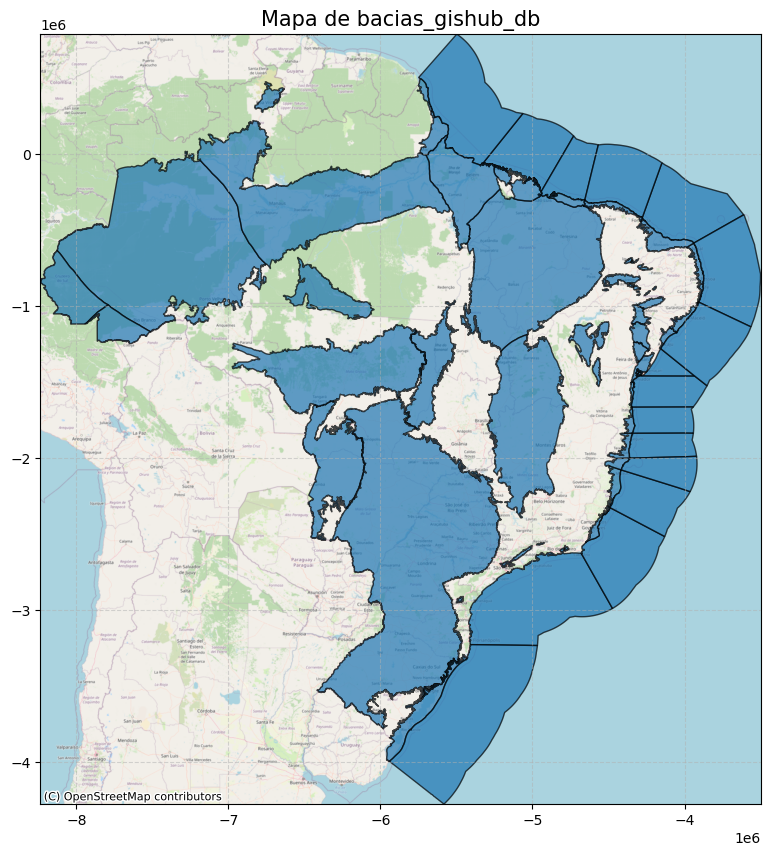

INFO: Map saved to ./dados/plots\bacias_gishub_db_map.png
INFO: Diagnosing BLOCOS_EXPLORATORIOS_SIRGASPolygon
INFO: CRS: EPSG:4674
INFO: Bounds: [-66.28645833 -34.75       -35.25         5.49969505]
INFO: Valid Geometry: True
INFO: BLOCOS_EXPLORATORIOS_SIRGASPolygon: All geometries valid? True
INFO: Transforming CRS of BLOCOS_EXPLORATORIOS_SIRGASPolygon to EPSG:3857


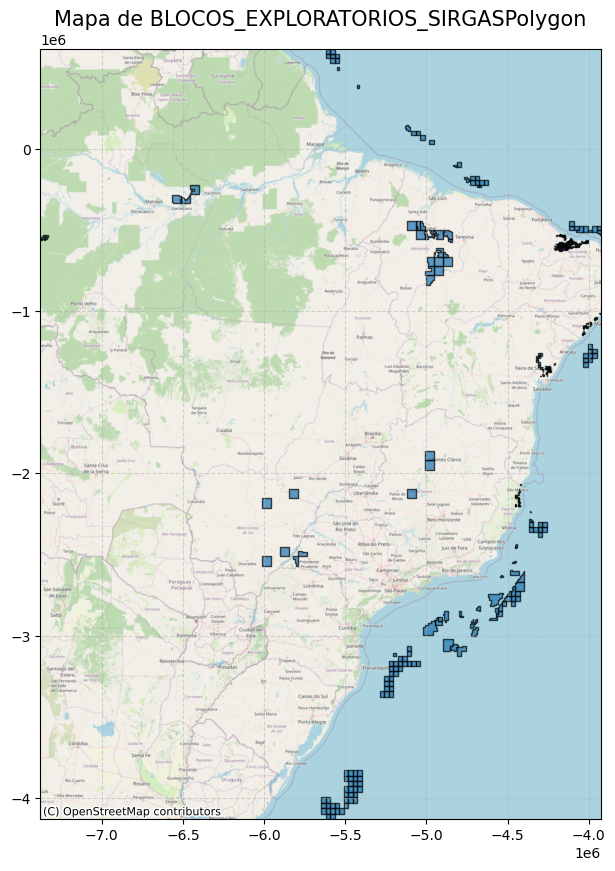

INFO: Map saved to ./dados/plots\BLOCOS_EXPLORATORIOS_SIRGASPolygon_map.png
INFO: Diagnosing CAMPOS_PRODUCAO_SIRGASPolygon
INFO: CRS: EPSG:4674
INFO: Bounds: [-66.53385417 -26.49789817 -35.56803626  -2.4612975 ]
INFO: Valid Geometry: True
INFO: CAMPOS_PRODUCAO_SIRGASPolygon: All geometries valid? True
INFO: Transforming CRS of CAMPOS_PRODUCAO_SIRGASPolygon to EPSG:3857


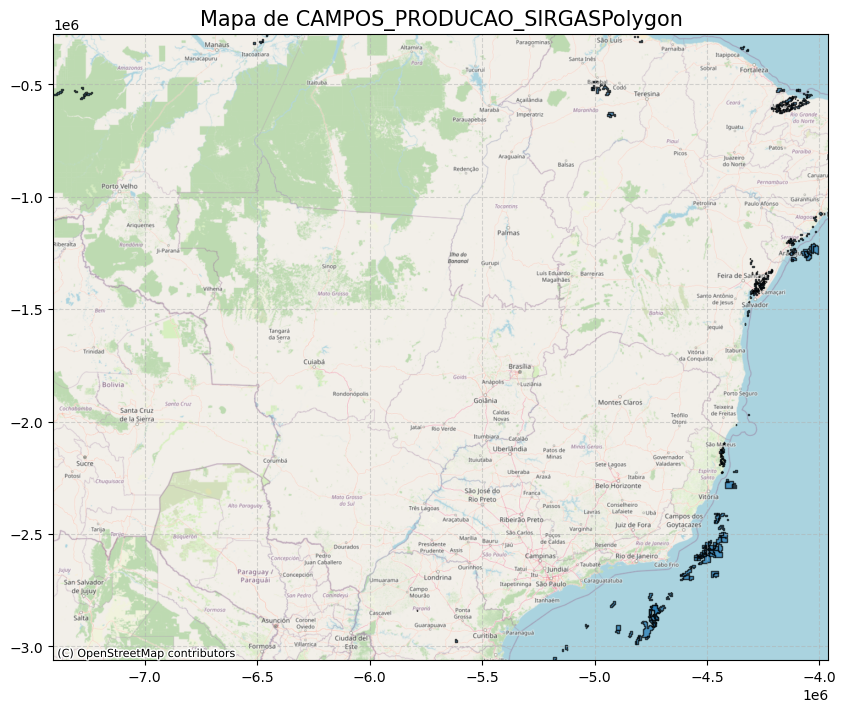

INFO: Map saved to ./dados/plots\CAMPOS_PRODUCAO_SIRGASPolygon_map.png
INFO: Diagnosing SETORES_TODOS_SIRGAS
INFO: CRS: EPSG:4674
INFO: Bounds: [-73.99442339 -35.5        -31.5          6.95833333]
INFO: Valid Geometry: False
INFO: Invalid geometries fixed for SETORES_TODOS_SIRGAS
INFO: SETORES_TODOS_SIRGAS: All geometries valid? True
INFO: Transforming CRS of SETORES_TODOS_SIRGAS to EPSG:3857


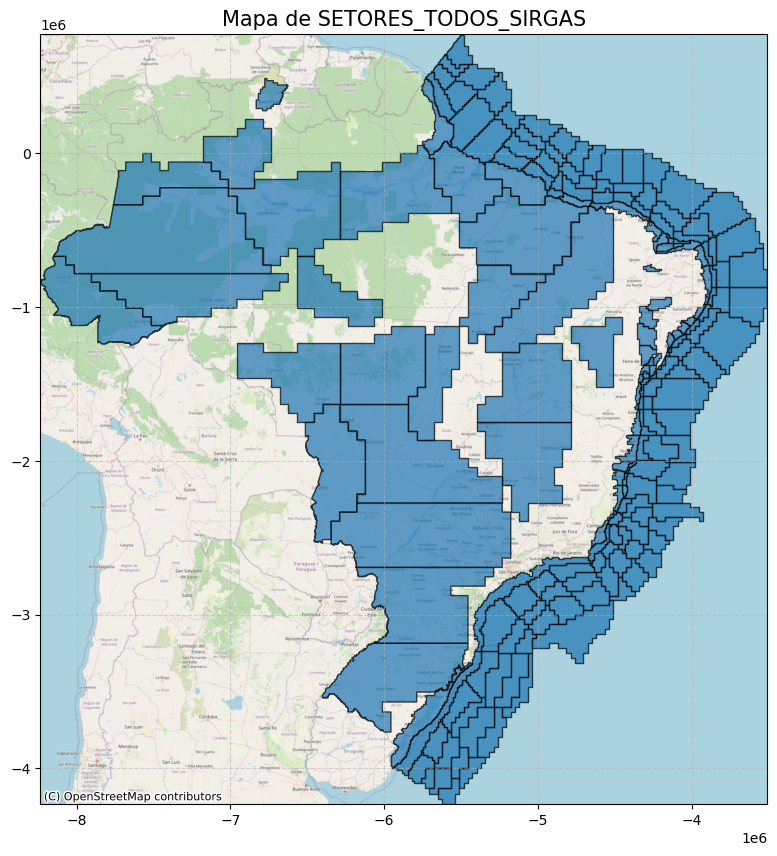

INFO: Map saved to ./dados/plots\SETORES_TODOS_SIRGAS_map.png
INFO: Provenance saved as XML: ./dados/prov\EDA-PROV.xml
INFO: Provenance saved as TTL: ./dados/prov\EDA-PROV.ttl
INFO: Provenance graph saved as PNG: ./dados/prov\EDA-PROV.png


Provenance graph generated successfully: EDA-PROV.png
Provenance serialized as XML and TTL.


In [166]:
main()

In [96]:
#BLOCO DE ANÁLISE DE DADOS

In [136]:
def analyze_datasets(datasets):

    #Itera sobre todos os DataFrames e GeoDataFrames do conjunto de datasets,
    #imprimindo as colunas e os tipos de dados.

    for name, dataset in datasets.items():
        if isinstance(dataset, pd.DataFrame):
            print(f"DataFrame: {name}")
            print("Columns:")
            print(dataset.columns.tolist())
            print("Dtypes:")
            print(dataset.dtypes)
            print("\n" + "=" * 50 + "\n")

        elif isinstance(dataset, gpd.GeoDataFrame):
            print(f"GeoDataFrame: {name}")
            print("Columns:")
            print(dataset.columns.tolist())
            print("Dtypes:")
            print(dataset.dtypes)
            print("\n" + "=" * 50 + "\n")

        else:
            print(f"Objeto '{name}' não é um DataFrame nem um GeoDataFrame. Ignorando...\n")

# Chamar a função após carregar os datasets na função `main`
# Isso carrega os datasets usando a lógica implementada no `main`

# Analisar os datasets carregados
print("Análise Básica dos Datasets:")
analyze_datasets(datasets)

Análise Básica dos Datasets:
DataFrame: df_sismica_2023_orig
Columns:
['Nome', 'Categoria', 'Tipo', 'Autorização', 'Inicio', 'Término Real', 'Confidencialidade', 'Público em', 'Ato Normativo', 'Tecnologia', 'Bloco', 'Campo', 'Bacia', 'E.A.D', 'Operadora']
Dtypes:
Nome                  object
Categoria             object
Tipo                  object
Autorização          float64
Inicio                object
Término Real          object
Confidencialidade     object
Público em            object
Ato Normativo         object
Tecnologia            object
Bloco                 object
Campo                 object
Bacia                 object
E.A.D                 object
Operadora             object
dtype: object


DataFrame: df_pocos_orig
Columns:
['POCO', 'CADASTRO', 'OPERADOR', 'POCO_OPERADOR', 'ESTADO', 'BACIA', 'BLOCO', 'SIG_CAMPO', 'CAMPO', 'TERRA_MAR', 'POCO_POS_ANP', 'TIPO', 'CATEGORIA', 'RECLASSIFICACAO', 'SITUACAO', 'INÍCIO', 'TÉRMINO', 'CONCLUSAO', 'TITULARIDADE', 'LATITUDE_BASE_4C', 

In [137]:
def map_filenames_to_datasets(file_list, expected_datasets):
    """
    Mapeia os nomes reais dos arquivos no diretório para os nomes esperados no código,
    lidando com pequenas diferenças nos nomes.
    """
    mapped_files = {}
    for dataset_name in expected_datasets:
        # Substitui underscores por hifens e procura por correspondências
        pattern = re.sub(r"_", r"[-_]", dataset_name)
        match = next((file for file in file_list if re.search(pattern, file, re.IGNORECASE)), None)
        
        if match:
            mapped_files[dataset_name] = match
        else:
            print(f"Dataset '{dataset_name}' não encontrado no diretório.")
    return mapped_files

def load_datasets(input_dir):

    #Carrega datasets de um diretório especificado.
    #Retorna um dicionário de DataFrames ou GeoDataFrames.

    if not os.path.exists(input_dir):
        raise FileNotFoundError(f"O diretório '{input_dir}' não foi encontrado. Por favor, crie-o e adicione os arquivos necessários.")

    datasets = {}
    files = os.listdir(input_dir)

    if not files:
        print(f"Aviso: O diretório '{input_dir}' está vazio. Nenhum arquivo foi carregado.")
        return datasets

    print(f"Arquivos encontrados no diretório '{input_dir}': {files}")
    for file in files:
        try:
            if file.endswith(".csv"):
                print(f"Carregando arquivo CSV: {file}")
                datasets[file.split(".")[0]] = pd.read_csv(os.path.join(input_dir, file), encoding="utf-8")
            elif file.endswith(".shp"):
                print(f"Carregando arquivo SHP: {file}")
                datasets[file.split(".")[0]] = gpd.read_file(os.path.join(input_dir, file))
        except Exception as e:
            print(f"Erro ao carregar arquivo '{file}': {e}")

    print(f"Datasets carregados: {list(datasets.keys())}")
    return datasets


def validate_datasets(datasets, output_dir):
    """
    Valida colunas e tipos, registrando inconsistências em logs.
    """
    os.makedirs(output_dir, exist_ok=True)
    log = []
    for name, df in datasets.items():
        log.append(f"\n=== Dataset: {name} ===")
        log.append(f"Shape: {df.shape}")
        log.append(f"Columns: {df.columns.tolist()}")
        log.append(f"Types:\n{df.dtypes}")

    # Adicionar resumo de erros ao final do log
    if not datasets:
        log.append("\nNenhum dataset válido foi carregado.")

    log_path = os.path.join(output_dir, "validation_log.txt")
    with open(log_path, "w", encoding="utf-8") as f:
        f.write("\n".join(log))
    print(f"Validation log saved to {log_path}")


def apply_type_definitions(datasets, type_definitions):
    """
    Aplica definições de tipos para as colunas dos datasets.
    Remove linhas inválidas e gera logs para elas.
    """
    log_changes = {}
    invalid_rows_log = {}

    for dataset_name, type_changes in type_definitions.items():
        if dataset_name not in datasets:
            print(f"Dataset '{dataset_name}' não encontrado. Pulando...")
            log_changes[dataset_name] = [{"Column": "N/A", "Before": "Dataset não encontrado", "After": "N/A"}]
            continue

        df = datasets[dataset_name]
        dataset_log = []
        invalid_rows = pd.DataFrame()

        for column, expected_type in type_changes.items():
            before_type = df[column].dtype if column in df.columns else "Ausente"
            try:
                if column not in df.columns:
                    print(f"Coluna '{column}' ausente em '{dataset_name}'. Adicionando...")
                    df[column] = None
                    after_type = "Adicionada"
                else:
                    original_rows = len(df)

                    if expected_type in ["int64", "float64"]:
                        # Substituir vírgulas por pontos para normalizar separadores decimais
                        df[column] = df[column].astype(str).str.replace(",", ".", regex=False)

                        # Verificar se é numérico, excluir strings inválidas
                        invalid = df[~df[column].str.replace(".", "", regex=False).str.isnumeric()]
                        invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)

                        # Converter para o tipo numérico apropriado
                        if expected_type == "int64":
                            df[column] = pd.to_numeric(df[column], errors="coerce", downcast="integer")
                        elif expected_type == "float64":
                            df[column] = pd.to_numeric(df[column], errors="coerce")

                        # Excluir linhas que não puderam ser convertidas
                        invalid = df[df[column].isna()]
                        invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)
                        df = df.dropna(subset=[column])

                        after_type = df[column].dtype
                        print(f"Removidas {original_rows - len(df)} linhas inválidas da coluna '{column}' em '{dataset_name}'.")
                    elif expected_type == "string":
                        try:
                            # Forçar a conversão para string
                            df[column] = df[column].astype(str)
                            # Identificar strings inválidas (e.g., espaços em branco)
                            invalid = df[df[column].str.match(r'^\s*$', na=False)]
                            if not invalid.empty:  # Verifica se existem linhas inválidas
                                invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)
                            # Remove linhas inválidas
                            df = df[~df[column].str.match(r'^\s*$', na=False)]
                            after_type = "string"
                            print(f"Removidas {original_rows - len(df)} linhas inválidas da coluna '{column}' em '{dataset_name}'.")
                        except Exception as e:
                            after_type = f"Erro ({e})"
                            print(f"Erro ao processar coluna '{column}' em '{dataset_name}': {e}")
                    elif expected_type == "date":
                        # Processar datas
                        df[column] = pd.to_datetime(df[column], format='%d/%m/%Y', errors="coerce", dayfirst=True)
                        invalid = df[df[column].isna()]
                        invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)
                        df = df.dropna(subset=[column])
                        after_type = df[column].dtype
                    elif expected_type == "geometry" and isinstance(df, gpd.GeoDataFrame):
                        df.set_geometry(column, inplace=True)
                        after_type = "geometry"
                    else:
                        raise ValueError(f"Tipo '{expected_type}' não suportado.")

            except Exception as e:
                after_type = f"Erro ({e})"
                print(f"Erro ao processar coluna '{column}' em '{dataset_name}': {e}")

            dataset_log.append({"Column": column, "Before": before_type, "After": after_type})

        # Salvar linhas inválidas, se houver
        if not invalid_rows.empty:
            invalid_rows_log[dataset_name] = invalid_rows

        datasets[dataset_name] = df
        log_changes[dataset_name] = dataset_log

    return datasets, log_changes, invalid_rows_log


def save_invalid_rows_logs(invalid_rows_log, output_dir):

    #Salva logs das linhas inválidas removidas.

    for dataset_name, invalid_rows in invalid_rows_log.items():
        invalid_log_path = os.path.join(output_dir, f"{dataset_name}_invalid_rows.csv")
        invalid_rows.to_csv(invalid_log_path, index=False, encoding="utf-8")
        print(f"Log de linhas inválidas salvo para '{dataset_name}': {invalid_log_path}")


def clean_datasets(datasets):

    #Limpa e ajusta colunas em datasets.

    for name, df in datasets.items():
        if isinstance(df, (pd.DataFrame, gpd.GeoDataFrame)):
            df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    return datasets


def save_datasets(datasets, output_dir, suffix="_sn"):

    #Salva os datasets tratados em um diretório, com sufixo.

    os.makedirs(output_dir, exist_ok=True)
    for name, df in datasets.items():
        try:
            if isinstance(df, gpd.GeoDataFrame):
                file_path = os.path.join(output_dir, f"{name}{suffix}.shp")
                df.to_file(file_path)
            else:
                file_path = os.path.join(output_dir, f"{name}{suffix}.csv")
                df.to_csv(file_path, index=False, encoding="utf-8")
            print(f"Dataset '{name}' salvo em: {file_path}")
        except Exception as e:
            print(f"Erro ao salvar dataset '{name}': {e}")


def generate_logs(log_data, output_dir):

    #Salva logs de alterações em arquivos.

    os.makedirs(output_dir, exist_ok=True)
    for dataset_name, changes in log_data.items():
        log_file = os.path.join(output_dir, f"{dataset_name}_type_changes.txt")
        try:
            pd.DataFrame(changes).to_csv(log_file, index=False, encoding="utf-8")
            print(f"Log saved for {dataset_name}: {log_file}")
        except Exception as e:
            print(f"Erro ao salvar log para '{dataset_name}': {e}")



In [138]:
"""def group_and_save(datasets, output_dir):
    
    #Agrupa os datasets por 'bacia', 'campo' e 'poço', e salva os resultados.
    #Gera plots básicos para análise.

    group_columns = {
        "bacia": "bacia",  # Ajuste o nome da coluna para o seu dataset
        "campo": "campo",  # Ajuste o nome da coluna para o seu dataset
        "poço": "poço"     # Ajuste o nome da coluna para o seu dataset
    }
    grouped_results = {}

    for group_name, group_col in group_columns.items():
        # Iterar por cada dataset
        for dataset_name, df in datasets.items():
            if group_col in df.columns:
                grouped = df.groupby(group_col).size().reset_index(name="count")
                grouped_results[f"{dataset_name}_{group_name}"] = grouped

                # Salvar agrupamento
                file_path = os.path.join(output_dir, f"{dataset_name}_grouped_by_{group_name}.csv")
                grouped.to_csv(file_path, index=False, encoding="utf-8")
                print(f"Agrupamento por '{group_name}' salvo em: {file_path}")

                # Gerar plot
                plt.figure(figsize=(10, 6))
                grouped.plot(kind="bar", x=group_col, y="count", legend=False, ax=plt.gca())
                plt.title(f"Agrupamento por {group_name} - {dataset_name}")
                plt.xlabel(group_name.capitalize())
                plt.ylabel("Frequência")
                plt.xticks(rotation=45, ha="right")
                plt.tight_layout()

                # Salvar plot
                plot_path = os.path.join(output_dir, f"{dataset_name}_grouped_by_{group_name}.png")
                plt.savefig(plot_path)
                print(f"Plot de agrupamento por '{group_name}' salvo em: {plot_path}")
                plt.close()

    return grouped_results    """


'def group_and_save(datasets, output_dir):\n    \n    #Agrupa os datasets por \'bacia\', \'campo\' e \'poço\', e salva os resultados.\n    #Gera plots básicos para análise.\n\n    group_columns = {\n        "bacia": "bacia",  # Ajuste o nome da coluna para o seu dataset\n        "campo": "campo",  # Ajuste o nome da coluna para o seu dataset\n        "poço": "poço"     # Ajuste o nome da coluna para o seu dataset\n    }\n    grouped_results = {}\n\n    for group_name, group_col in group_columns.items():\n        # Iterar por cada dataset\n        for dataset_name, df in datasets.items():\n            if group_col in df.columns:\n                grouped = df.groupby(group_col).size().reset_index(name="count")\n                grouped_results[f"{dataset_name}_{group_name}"] = grouped\n\n                # Salvar agrupamento\n                file_path = os.path.join(output_dir, f"{dataset_name}_grouped_by_{group_name}.csv")\n                grouped.to_csv(file_path, index=False, encoding="

In [139]:
def main2():

    #Pipeline principal com ajuste de tipos, agrupamento e visualizações.

    input_dir = "./dados/saidas"
    output_dir = "./dados/processed"
    type_definitions_path = "./dados/saved_definitions/type_definitions.json"

    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

    datasets = load_datasets(input_dir)

    validate_datasets(datasets, output_dir)

    with open(type_definitions_path, "r", encoding="utf-8") as file:
        type_definitions = json.load(file)

    datasets, logs, invalid_rows_log = apply_type_definitions(datasets, type_definitions)

    generate_logs(logs, output_dir)

    save_invalid_rows_logs(invalid_rows_log, output_dir)

    datasets = clean_datasets(datasets)

    save_datasets(datasets, output_dir)

    # Agrupar por bacia, campo e poço
    #grouped_results = group_and_save(datasets, output_dir)

    if invalid_rows_log:
        print("Pipeline concluído com alertas! Linhas inválidas foram removidas e registradas.")
    else:
        print("Pipeline concluído com sucesso!")

In [140]:
main2()

Arquivos encontrados no diretório './dados/saidas': ['.ipynb_checkpoints', 'dataset.csv', 'df_consolidacao-daa-2023-calha.csv.csv', 'df_consolidacao-daa-2023-fluidos.csv.csv', 'df_consolidacao-daa-2023-laminas.csv.csv', 'df_consolidacao-daa-2023-laterais.csv.csv', 'df_consolidacao-daa-2023-plugues.csv.csv', 'df_consolidacao-daa-2023-testemunhos.csv.csv', 'df_geoq_2021_orig.csv', 'df_lev_geoq_2022_orig.csv', 'df_pocos_orig.csv', 'df_poco_2023_orig.csv', 'df_reservas_orig.csv', 'df_sismica_2023_orig.csv', 'gdf_bacias.csv', 'gdf_blocos_exploratorios.csv', 'gdf_campos_producao.csv', 'gdf_setores_sirgas.csv']
Carregando arquivo CSV: dataset.csv
Carregando arquivo CSV: df_consolidacao-daa-2023-calha.csv.csv


C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:38: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  datasets[file.split(".")[0]] = pd.read_csv(os.path.join(input_dir, file), encoding="utf-8")


Carregando arquivo CSV: df_consolidacao-daa-2023-fluidos.csv.csv
Carregando arquivo CSV: df_consolidacao-daa-2023-laminas.csv.csv


C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:38: DtypeWarning: Columns (1,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  datasets[file.split(".")[0]] = pd.read_csv(os.path.join(input_dir, file), encoding="utf-8")
C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:38: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  datasets[file.split(".")[0]] = pd.read_csv(os.path.join(input_dir, file), encoding="utf-8")


Carregando arquivo CSV: df_consolidacao-daa-2023-laterais.csv.csv
Carregando arquivo CSV: df_consolidacao-daa-2023-plugues.csv.csv


C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:38: DtypeWarning: Columns (1,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  datasets[file.split(".")[0]] = pd.read_csv(os.path.join(input_dir, file), encoding="utf-8")


Carregando arquivo CSV: df_consolidacao-daa-2023-testemunhos.csv.csv
Carregando arquivo CSV: df_geoq_2021_orig.csv
Carregando arquivo CSV: df_lev_geoq_2022_orig.csv
Carregando arquivo CSV: df_pocos_orig.csv
Carregando arquivo CSV: df_poco_2023_orig.csv
Carregando arquivo CSV: df_reservas_orig.csv
Carregando arquivo CSV: df_sismica_2023_orig.csv
Carregando arquivo CSV: gdf_bacias.csv
Carregando arquivo CSV: gdf_blocos_exploratorios.csv
Carregando arquivo CSV: gdf_campos_producao.csv
Carregando arquivo CSV: gdf_setores_sirgas.csv
Datasets carregados: ['dataset', 'df_consolidacao-daa-2023-calha', 'df_consolidacao-daa-2023-fluidos', 'df_consolidacao-daa-2023-laminas', 'df_consolidacao-daa-2023-laterais', 'df_consolidacao-daa-2023-plugues', 'df_consolidacao-daa-2023-testemunhos', 'df_geoq_2021_orig', 'df_lev_geoq_2022_orig', 'df_pocos_orig', 'df_poco_2023_orig', 'df_reservas_orig', 'df_sismica_2023_orig', 'gdf_bacias', 'gdf_blocos_exploratorios', 'gdf_campos_producao', 'gdf_setores_sirgas']

C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)
C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)


Removidas 0 linhas inválidas da coluna 'TITULARIDADE' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'LATITUDE_BASE_4C' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'LONGITUDE_BASE_4C' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'LATITUDE_BASE_DD' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'LONGITUDE_BASE_DD' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'DATUM_HORIZONTAL' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'TIPO_DE_COORDENADA_DE_BASE' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'DIRECAO' em 'df_pocos_orig'.
Removidas 17177 linhas inválidas da coluna 'PROFUNDIDADE_VERTICAL_M' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'PROFUNDIDADE_SONDADOR_M' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'PROFUNDIDADE_MEDIDA_M' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da coluna 'REFERENCIA_DE_PROFUNDIDADE' em 'df_pocos_orig'.
Removidas 0 linhas inválidas da 

C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)


Removidas 7 linhas inválidas da coluna 'Análise de Óleo' em 'df_geoq_2021_orig'.
Removidas 1 linhas inválidas da coluna 'Análise de Gás' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Análise de Fluidos' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Análise de Água' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Biomarcadores' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Aromáticos' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Saturados' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Isótopos' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Espectrometria de Massas' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Diamantoides' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Carbono Orgânico Total' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna 'Pirólise' em 'df_geoq_2021_orig'.
Removidas 0 linhas inválidas da coluna '

C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)
C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)
C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:139: FutureWarning: The behavior of DataFrame concatenation with emp

Removidas 0 linhas inválidas da coluna 'ID1' em 'gdf_setores_sirgas'.
Removidas 0 linhas inválidas da coluna 'BACIA' em 'gdf_setores_sirgas'.
Removidas 0 linhas inválidas da coluna 'NOME_SETOR' em 'gdf_setores_sirgas'.
Removidas 0 linhas inválidas da coluna 'ID1' em 'gdf_bacias'.
Removidas 0 linhas inválidas da coluna 'BACIA' em 'gdf_bacias'.
Removidas 0 linhas inválidas da coluna 'NOME_SETOR' em 'gdf_bacias'.
Removidas 0 linhas inválidas da coluna 'COD_BLOCO' em 'gdf_blocos_exploratorios'.
Removidas 0 linhas inválidas da coluna 'COD_FASE_C' em 'gdf_blocos_exploratorios'.
Removidas 0 linhas inválidas da coluna 'NOM_BACIA' em 'gdf_blocos_exploratorios'.
Removidas 0 linhas inválidas da coluna 'NOM_BLOCO' em 'gdf_blocos_exploratorios'.
Removidas 0 linhas inválidas da coluna 'NOM_FANTAS' em 'gdf_blocos_exploratorios'.
Removidas 0 linhas inválidas da coluna 'NUM_CONTRA' em 'gdf_blocos_exploratorios'.
Removidas 0 linhas inválidas da coluna 'NUM_DESCOB' em 'gdf_blocos_exploratorios'.
Removida

C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)
C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  invalid_rows = pd.concat([invalid_rows, invalid], ignore_index=True)
C:\Users\ubira\AppData\Local\Temp\ipykernel_33216\2902045425.py:139: FutureWarning: The behavior of DataFrame concatenation with emp

Log de linhas inválidas salvo para 'df_pocos_orig': ./dados/processed\df_pocos_orig_invalid_rows.csv
Log de linhas inválidas salvo para 'df_lev_geoq_2022_orig': ./dados/processed\df_lev_geoq_2022_orig_invalid_rows.csv
Log de linhas inválidas salvo para 'df_geoq_2021_orig': ./dados/processed\df_geoq_2021_orig_invalid_rows.csv
Log de linhas inválidas salvo para 'df_reservas_orig': ./dados/processed\df_reservas_orig_invalid_rows.csv
Log de linhas inválidas salvo para 'df_poco_2023_orig': ./dados/processed\df_poco_2023_orig_invalid_rows.csv
Log de linhas inválidas salvo para 'gdf_blocos_exploratorios': ./dados/processed\gdf_blocos_exploratorios_invalid_rows.csv
Log de linhas inválidas salvo para 'gdf_campos_producao': ./dados/processed\gdf_campos_producao_invalid_rows.csv
Dataset 'dataset' salvo em: ./dados/processed\dataset_sn.csv
Dataset 'df_consolidacao-daa-2023-calha' salvo em: ./dados/processed\df_consolidacao-daa-2023-calha_sn.csv
Dataset 'df_consolidacao-daa-2023-fluidos' salvo em: 

In [141]:
########################################################################################

In [142]:

# Carregando os arquivos
df_pocos_orig = pd.read_csv("./dados/raw/Tabela_pocos_2024_Novembro_24.csv", encoding="latin-1", sep=";")
df_calha_sn = pd.read_csv("./dados/processed/df_consolidacao_daa_2023_calha.csv_sn.csv",encoding="utf-8", sep=",")


In [143]:
print("Colunas de df_pocos_orig:", df_pocos_orig.columns)
print("Colunas de df_calha_sn:", df_calha_sn.columns)

Colunas de df_pocos_orig: Index(['POCO', 'CADASTRO', 'OPERADOR', 'POCO_OPERADOR', 'ESTADO', 'BACIA',
       'BLOCO', 'SIG_CAMPO', 'CAMPO', 'TERRA_MAR', 'POCO_POS_ANP', 'TIPO',
       'CATEGORIA', 'RECLASSIFICACAO', 'SITUACAO', 'INÍCIO', 'TÉRMINO',
       'CONCLUSAO', 'TITULARIDADE', 'LATITUDE_BASE_4C', 'LONGITUDE_BASE_4C',
       'LATITUDE_BASE_DD', 'LONGITUDE_BASE_DD', 'DATUM_HORIZONTAL',
       'TIPO_DE_COORDENADA_DE_BASE', 'DIRECAO', 'PROFUNDIDADE_VERTICAL_M',
       'PROFUNDIDADE_SONDADOR_M', 'PROFUNDIDADE_MEDIDA_M',
       'REFERENCIA_DE_PROFUNDIDADE', 'MESA_ROTATIVA', 'COTA_ALTIMETRICA_M',
       'LAMINA_D_AGUA_M', 'DATUM_VERTICAL', 'UNIDADE_ESTRATIGRAFICA',
       'GEOLOGIA_GRUPO_FINAL', 'GEOLOGIA_FORMACAO_FINAL',
       'GEOLOGIA_MEMBRO_FINAL', 'CDPE', 'AGP', 'PC', 'PAG',
       'PERFIS_CONVENCIONAIS', 'DURANTE_PERFURACAO', 'PERFIS_DIGITAIS',
       'PERFIS_PROCESSADOS', 'PERFIS_ESPECIAIS', 'AMOSTRA_LATERAL', 'SISMICA',
       'TABELA_TEMPO_PROFUNDIDADE', 'DADOS_DIRECIONAIS', '

In [154]:
# Renomear colunas para uniformizar os DataFrames
df_calha = df_calha_orig.rename(columns={'Nome do poço (ANP)': 'POCO'})

print(df_calha)

           bacia_sedimentar código_do_poço_(api) nome_do_poço_(anp)  \
0             ALAGOAS TERRA        81150190500.0         1-ARP-2-AL   
1             ALAGOAS TERRA        81150190500.0         1-ARP-2-AL   
2             ALAGOAS TERRA        81150190500.0         1-ARP-2-AL   
3             ALAGOAS TERRA        81150190500.0         1-ARP-2-AL   
4             ALAGOAS TERRA        81150347500.0         1-BAR-1-AL   
...                     ...                  ...                ...   
57888  ESPÍRITO SANTO TERRA          34270025110       1-VITA-12-ES   
57889  ESPÍRITO SANTO TERRA          34270025345       3-VITA-13-ES   
57890  ESPÍRITO SANTO TERRA          34270027117       3-VITA-14-ES   
57891  ESPÍRITO SANTO TERRA          34270027378       1-VITA-15-ES   
57892  ESPÍRITO SANTO TERRA          34270027958       3-VITA-16-ES   

      identificador_da_caixa  total_de_caixas  profundidade_topo_(m)  \
0                          1             15.0                   27.0   
1  

In [155]:
df_test = df_calha.merge (df_pocos_orig, on="POCO", how="inner")


KeyError: 'POCO'

In [ ]:
#################################################################################################

In [ ]:
"""def analyze_datasets(datasets):

    #Itera sobre todos os DataFrames e GeoDataFrames do conjunto de datasets,
    #imprimindo as colunas e os tipos de dados.

    for name, dataset in datasets.items():
        if isinstance(dataset, pd.DataFrame):
            print(f"DataFrame: {name}")
            print("Columns:")
            print(dataset.columns.tolist())
            print("Dtypes:")
            print(dataset.dtypes)
            print("\n" + "=" * 50 + "\n")

        elif isinstance(dataset, gpd.GeoDataFrame):
            print(f"GeoDataFrame: {name}")
            print("Columns:")
            print(dataset.columns.tolist())
            print("Dtypes:")
            print(dataset.dtypes)
            print("\n" + "=" * 50 + "\n")

        else:
            print(f"Objeto '{name}' não é um DataFrame nem um GeoDataFrame. Ignorando...\n")

# Chamar a função após carregar os datasets na função `main`
# Isso carrega os datasets usando a lógica implementada no `main`

# Analisar os datasets carregados
print("Análise Básica dos Datasets:")
analyze_datasets(datasets)
"""

In [ ]:
"""def list_datasets(datasets):
    """
"""Lista todos os datasets carregados, incluindo o número de colunas e registros.
    Args:
        datasets (dict): Dicionário contendo DataFrames e GeoDataFrames.
    Returns:
        None: Imprime informações sobre os datasets.
    """
"""print("Datasets disponíveis:\n")
    for name, dataset in datasets.items():
        if isinstance(dataset, pd.DataFrame):
            dataset_type = "DataFrame"
        elif isinstance(dataset, gpd.GeoDataFrame):
            dataset_type = "GeoDataFrame"
        else:
            dataset_type = "Outro Tipo"

        print(f"Nome: {name}")
        print(f"  Tipo: {dataset_type}")
        print(f"  Registros: {dataset.shape[0]}")
        print(f"  Colunas: {dataset.shape[1]}")
        print("=" * 50)

# Exemplo de uso
list_datasets(datasets)"""

In [ ]:
##############################################################################################